In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

from sklearn.metrics import roc_auc_score, make_scorer
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted
import missingno as msno
import xgboost as xgb, lightgbm as lgbm, catboost as cb
from sklearn.linear_model import LogisticRegression

%matplotlib inline
import time
from typing import List, Optional
from sklearn.decomposition import PCA
import seaborn as sns
import scipy.stats as st
from scipy.stats import probplot, ks_2samp

import shap
shap.initjs()

import warnings
warnings.simplefilter("ignore")

In [3]:
df_train = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/train.csv')
df_test = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/test.csv')
df_application = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/applications_history.csv')
df_bki = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/bki.csv')
df_client_profile = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/client_profile.csv')
df_payments = pd.read_csv('/Kaggle/input/geekbrains-competitive-data-analysis/payments.csv')


In [4]:
df_train.head()

APPLICATION_NUMBER  TARGET NAME_CONTRACT_TYPE
0           123687442       0               Cash
1           123597908       1               Cash
2           123526683       0               Cash
3           123710391       1               Cash
4           123590329       1               Cash

In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110093 entries, 0 to 110092
Data columns (total 3 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  110093 non-null  int64 
 1   TARGET              110093 non-null  int64 
 2   NAME_CONTRACT_TYPE  110093 non-null  object
dtypes: int64(2), object(1)
memory usage: 2.5+ MB


In [6]:
df_test.head()

APPLICATION_NUMBER NAME_CONTRACT_TYPE
0           123724268               Cash
1           123456549               Cash
2           123428178        Credit Card
3           123619984               Cash
4           123671104               Cash

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165141 entries, 0 to 165140
Data columns (total 2 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   APPLICATION_NUMBER  165141 non-null  int64 
 1   NAME_CONTRACT_TYPE  165141 non-null  object
dtypes: int64(1), object(1)
memory usage: 2.5+ MB


трейн и тест без пропусков. любопытный момент, что в тесте данных больше, чем в трейне. 

In [8]:
df_application.head()

PREV_APPLICATION_NUMBER  APPLICATION_NUMBER NAME_CONTRACT_TYPE  \
0                 49298709           123595216                NaN   
1                 50070639           123431468               Cash   
2                 49791680           123445379               Cash   
3                 50087457           123499497               Cash   
4                 49052479           123525393               Cash   

   AMOUNT_ANNUITY  AMT_APPLICATION  AMOUNT_CREDIT  AMOUNT_PAYMENT  \
0        1730.430          17145.0        17145.0             0.0   
1       25188.615         607500.0       679671.0             NaN   
2       15060.735         112500.0       136444.5             NaN   
3       47041.335         450000.0       470790.0             NaN   
4       31924.395         337500.0       404055.0             NaN   

   AMOUNT_GOODS_PAYMENT NAME_CONTRACT_STATUS  DAYS_DECISION  ...  \
0               17145.0             Approved             73  ...   
1              607500.0             Approved            164  ...   
2              112500.0             Approved            301  ...   
3              450000.0             Approved            512  ...   
4              337500.0              Refused            781  ...   

  NAME_PRODUCT_TYPE SELLERPLACE_AREA CNT_PAYMENT NAME_YIELD_GROUP  \
0               XNA               35        12.0           middle   
1            x-sell               -1        36.0       low_action   
2            x-sell               -1        12.0             high   
3            x-sell               -1        12.0           middle   
4           walk-in               -1        24.0             high   

  DAYS_FIRST_DRAWING DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  \
0           365243.0           42.0                     300.0           42.0   
1           365243.0          134.0                     916.0       365243.0   
2           365243.0          271.0                      59.0       365243.0   
3           365243.0          482.0                     152.0          182.0   
4                NaN            NaN                       NaN            NaN   

   DAYS_TERMINATION NFLAG_INSURED_ON_APPROVAL  
0              37.0                       0.0  
1          365243.0                       1.0  
2          365243.0                       1.0  
3             177.0                       1.0  
4               NaN                       NaN  

[5 rows x 26 columns]

In [9]:
df_application.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1670214 entries, 0 to 1670213
Data columns (total 26 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   PREV_APPLICATION_NUMBER    1670214 non-null  int64  
 1   APPLICATION_NUMBER         1670214 non-null  int64  
 2   NAME_CONTRACT_TYPE         940717 non-null   object 
 3   AMOUNT_ANNUITY             1297979 non-null  float64
 4   AMT_APPLICATION            1670214 non-null  float64
 5   AMOUNT_CREDIT              1670213 non-null  float64
 6   AMOUNT_PAYMENT             774370 non-null   float64
 7   AMOUNT_GOODS_PAYMENT       1284699 non-null  float64
 8   NAME_CONTRACT_STATUS       1670214 non-null  object 
 9   DAYS_DECISION              1670214 non-null  int64  
 10  NAME_PAYMENT_TYPE          1670214 non-null  object 
 11  CODE_REJECT_REASON         1670214 non-null  object 
 12  NAME_TYPE_SUITE            849809 non-null   object 
 13  NAME_CLIENT_

In [10]:
df_bki.head()

APPLICATION_NUMBER  BUREAU_ID CREDIT_ACTIVE CREDIT_CURRENCY  DAYS_CREDIT  \
0           123538884    5223613        Active      currency 1        718.0   
1           123436670    6207544        Closed      currency 1        696.0   
2           123589020    6326395        Closed      currency 1        165.0   
3           123494590    6606618        Active      currency 1         55.0   
4           123446603    5046832        Active      currency 1        358.0   

   CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  \
0                   0                377.0                NaN   
1                   0                511.0              511.0   
2                   0                149.0              160.0   
3                   0                310.0                NaN   
4                   0                 35.0                NaN   

   AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  \
0                19386.81                   0       675000.00   
1                    0.00                   0        93111.66   
2                     NaN                   0        36000.00   
3                     NaN                   0        38664.00   
4                     NaN                   0        67500.00   

   AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  \
0           320265.495                   0.0                     0.0   
1                0.000                   0.0                     0.0   
2                0.000                   0.0                     0.0   
3            37858.500                   NaN                     0.0   
4                0.000                   0.0                     0.0   

       CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0  Consumer credit                39.0          NaN  
1  Consumer credit               505.0          NaN  
2  Consumer credit               150.0          0.0  
3  Consumer credit                15.0          NaN  
4      Credit card               116.0          NaN

In [11]:
df_bki.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 945234 entries, 0 to 945233
Data columns (total 17 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   APPLICATION_NUMBER      945234 non-null  int64  
 1   BUREAU_ID               945234 non-null  int64  
 2   CREDIT_ACTIVE           945234 non-null  object 
 3   CREDIT_CURRENCY         945234 non-null  object 
 4   DAYS_CREDIT             945234 non-null  float64
 5   CREDIT_DAY_OVERDUE      945234 non-null  int64  
 6   DAYS_CREDIT_ENDDATE     886797 non-null  float64
 7   DAYS_ENDDATE_FACT       596274 non-null  float64
 8   AMT_CREDIT_MAX_OVERDUE  326557 non-null  float64
 9   CNT_CREDIT_PROLONG      945234 non-null  int64  
 10  AMT_CREDIT_SUM          945229 non-null  float64
 11  AMT_CREDIT_SUM_DEBT     803483 non-null  float64
 12  AMT_CREDIT_SUM_LIMIT    619267 non-null  float64
 13  AMT_CREDIT_SUM_OVERDUE  945234 non-null  float64
 14  CREDIT_TYPE         

In [12]:
df_client_profile.head()

APPLICATION_NUMBER GENDER  CHILDRENS  TOTAL_SALARY  AMOUNT_CREDIT  \
0           123666076      F          0      157500.0       270000.0   
1           123423688      F          0      270000.0       536917.5   
2           123501780      M          1      427500.0       239850.0   
3           123588799      M          0      112500.0       254700.0   
4           123647485      M          0      130500.0       614574.0   

   AMOUNT_ANNUITY                EDUCATION_LEVEL   FAMILY_STATUS  \
0         13500.0              Incomplete higher  Civil marriage   
1         28467.0  Secondary / secondary special         Married   
2         23850.0              Incomplete higher         Married   
3         17149.5  Secondary / secondary special         Married   
4         19822.5                Lower secondary         Married   

   REGION_POPULATION    AGE  ...  FAMILY_SIZE  EXTERNAL_SCORING_RATING_1  \
0           0.008068   8560  ...          2.0                   0.329471   
1           0.020246  23187  ...          2.0                        NaN   
2           0.072508  14387  ...          3.0                   0.409017   
3           0.019101  14273  ...          2.0                        NaN   
4           0.022625  22954  ...          2.0                        NaN   

   EXTERNAL_SCORING_RATING_2  EXTERNAL_SCORING_RATING_3  \
0                   0.236315                   0.678568   
1                   0.442295                   0.802745   
2                   0.738159                        NaN   
3                   0.308994                   0.590233   
4                   0.739408                   0.156640   

   AMT_REQ_CREDIT_BUREAU_HOUR  AMT_REQ_CREDIT_BUREAU_DAY  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         NaN                        NaN   
3                         0.0                        0.0   
4                         0.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                         0.0                        0.0   
1                         0.0                        0.0   
2                         NaN                        NaN   
3                         0.0                        0.0   
4                         1.0                        0.0   

   AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  
0                        1.0                         2.0  
1                        1.0                         1.0  
2                        NaN                         NaN  
3                        0.0                         3.0  
4                        0.0                         6.0  

[5 rows x 24 columns]

In [13]:
df_client_profile.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 24 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          250000 non-null  int64  
 1   GENDER                      250000 non-null  object 
 2   CHILDRENS                   250000 non-null  int64  
 3   TOTAL_SALARY                250000 non-null  float64
 4   AMOUNT_CREDIT               250000 non-null  float64
 5   AMOUNT_ANNUITY              249989 non-null  float64
 6   EDUCATION_LEVEL             250000 non-null  object 
 7   FAMILY_STATUS               250000 non-null  object 
 8   REGION_POPULATION           250000 non-null  float64
 9   AGE                         250000 non-null  int64  
 10  DAYS_ON_LAST_JOB            250000 non-null  int64  
 11  OWN_CAR_AGE                 85041 non-null   float64
 12  FLAG_PHONE                  250000 non-null  int64  
 13  FLAG_EMAIL    

In [14]:
df_payments.head()

PREV_APPLICATION_NUMBER  APPLICATION_NUMBER  NUM_INSTALMENT_VERSION  \
0                 49011181           123664960                     1.0   
1                 48683432           123497205                     1.0   
2                 48652024           123749925                     1.0   
3                 48398897           123550846                     0.0   
4                 49867197           123562174                     0.0   

   NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  AMT_INSTALMENT  \
0                      5           1002.0              1015.0       12156.615   
1                     13            442.0               432.0       18392.535   
2                     10              8.0                23.0        5499.945   
3                     82            398.0               398.0        7082.145   
4                     63           1359.0              1359.0         156.735   

   AMT_PAYMENT  
0    12156.615  
1    10047.645  
2     5499.945  
3     7082.145  
4      156.735

In [15]:
df_payments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1023932 entries, 0 to 1023931
Data columns (total 8 columns):
 #   Column                   Non-Null Count    Dtype  
---  ------                   --------------    -----  
 0   PREV_APPLICATION_NUMBER  1023932 non-null  int64  
 1   APPLICATION_NUMBER       1023932 non-null  int64  
 2   NUM_INSTALMENT_VERSION   1023932 non-null  float64
 3   NUM_INSTALMENT_NUMBER    1023932 non-null  int64  
 4   DAYS_INSTALMENT          1023932 non-null  float64
 5   DAYS_ENTRY_PAYMENT       1023729 non-null  float64
 6   AMT_INSTALMENT           1023932 non-null  float64
 7   AMT_PAYMENT              1023729 non-null  float64
dtypes: float64(5), int64(3)
memory usage: 62.5 MB


In [16]:
df_train_merged = pd.merge(df_train, df_application, on=('APPLICATION_NUMBER'))


In [17]:
df_train_merged

APPLICATION_NUMBER  TARGET NAME_CONTRACT_TYPE_x  \
0                123687442       0                 Cash   
1                123687442       0                 Cash   
2                123687442       0                 Cash   
3                123597908       1                 Cash   
4                123597908       1                 Cash   
...                    ...     ...                  ...   
516110           123723001       0                 Cash   
516111           123723001       0                 Cash   
516112           123554358       0                 Cash   
516113           123554358       0                 Cash   
516114           123676265       0          Credit Card   

        PREV_APPLICATION_NUMBER NAME_CONTRACT_TYPE_y  AMOUNT_ANNUITY  \
0                      49915814                  NaN        6510.015   
1                      49713743                  NaN        9262.215   
2                      49704707                  NaN        7339.185   
3                      48716994                 Cash       38667.600   
4                      49672074                  NaN       11349.900   
...                         ...                  ...             ...   
516110                 49650758                  NaN        4998.645   
516111                 49065356                  NaN        3001.950   
516112                 49515687                  NaN       20264.805   
516113                 49102720                 Cash       29256.615   
516114                 49159579                  NaN       15902.910   

        AMT_APPLICATION  AMOUNT_CREDIT  AMOUNT_PAYMENT  AMOUNT_GOODS_PAYMENT  \
0             71668.800        64500.3        7168.500             71668.800   
1             72634.140        70758.0        7267.140             72634.140   
2             62058.600        67518.0           3.600             62058.600   
3            495000.000       672948.0             NaN            495000.000   
4             75510.000        82156.5           0.000             75510.000   
...                 ...            ...             ...                   ...   
516110        34245.000        27207.0        8563.500             34245.000   
516111        26482.500        29281.5           0.000             26482.500   
516112       261180.000       287037.0           0.000            261180.000   
516113       337500.000       368685.0             NaN            337500.000   
516114       146929.095       143140.5       14696.595            146929.095   

        ... NAME_PRODUCT_TYPE  SELLERPLACE_AREA CNT_PAYMENT NAME_YIELD_GROUP  \
0       ...               XNA                20        12.0           middle   
1       ...               XNA                90        10.0             high   
2       ...               XNA               150        10.0       low_action   
3       ...            x-sell                -1        36.0             high   
4       ...               XNA                12        10.0             high   
...     ...               ...               ...         ...              ...   
516110  ...               XNA               156         6.0       low_normal   
516111  ...               XNA               156        12.0           middle   
516112  ...               XNA               100        18.0           middle   
516113  ...           walk-in                32        24.0             high   
516114  ...               XNA                -1        10.0       low_normal   

       DAYS_FIRST_DRAWING DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  \
0                365243.0          143.0                     187.0   
1                365243.0         2671.0                    2401.0   
2                365243.0          690.0                     420.0   
3                     NaN            NaN                       NaN   
4                365243.0          690.0                     420.0   
...                   ...            ...                       ...   
516110           36524

In [18]:
df_application[df_application['APPLICATION_NUMBER'] == 123687442]

PREV_APPLICATION_NUMBER  APPLICATION_NUMBER NAME_CONTRACT_TYPE  \
239762                 49915814           123687442                NaN   
509872                 49713743           123687442                NaN   
626049                 49704707           123687442                NaN   

        AMOUNT_ANNUITY  AMT_APPLICATION  AMOUNT_CREDIT  AMOUNT_PAYMENT  \
239762        6510.015         71668.80        64500.3         7168.50   
509872        9262.215         72634.14        70758.0         7267.14   
626049        7339.185         62058.60        67518.0            3.60   

        AMOUNT_GOODS_PAYMENT NAME_CONTRACT_STATUS  DAYS_DECISION  ...  \
239762              71668.80             Approved            240  ...   
509872              72634.14             Approved           2702  ...   
626049              62058.60             Approved            721  ...   

       NAME_PRODUCT_TYPE SELLERPLACE_AREA CNT_PAYMENT NAME_YIELD_GROUP  \
239762               XNA               20        12.0           middle   
509872               XNA               90        10.0             high   
626049               XNA              150        10.0       low_action   

       DAYS_FIRST_DRAWING DAYS_FIRST_DUE DAYS_LAST_DUE_1ST_VERSION  \
239762           365243.0          143.0                     187.0   
509872           365243.0         2671.0                    2401.0   
626049           365243.0          690.0                     420.0   

        DAYS_LAST_DUE  DAYS_TERMINATION NFLAG_INSURED_ON_APPROVAL  
239762       365243.0          365243.0                       0.0  
509872         2401.0            2368.0                       1.0  
626049          420.0             415.0                       0.0  

[3 rows x 26 columns]

мы видим, что к одному номеру заявки относится несколько история из нескольких заявок, которую нужно дополнительно обработать. иначе таблица трейна и теста у нас разбухает от данных. пока оставим ее, попробуем объединить с другими таблицами.

In [19]:
df_train_merged = pd.merge(df_train, df_bki, on=('APPLICATION_NUMBER'))


In [20]:
df_train_merged.head()

APPLICATION_NUMBER  TARGET NAME_CONTRACT_TYPE  BUREAU_ID CREDIT_ACTIVE  \
0           123687442       0               Cash    5640206        Closed   
1           123597908       1               Cash    5970760        Closed   
2           123597908       1               Cash    5923029        Closed   
3           123597908       1               Cash    5952522        Active   
4           123597908       1               Cash    5912683        Closed   

  CREDIT_CURRENCY  DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  \
0      currency 1       2562.0                   0               2197.0   
1      currency 1       1809.0                   0               1475.0   
2      currency 1        434.0                   0                130.0   
3      currency 1        141.0                   0                225.0   
4      currency 1       1213.0                   0                 86.0   

   DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  \
0             2162.0                4714.425                   0   
1             1503.0                     NaN                   0   
2              130.0                   0.000                   0   
3                NaN                     NaN                   0   
4               98.0                     NaN                   0   

   AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  \
0         56362.5                  0.0                   0.0   
1         56376.0                  0.0                   NaN   
2        137910.6                  0.0                   0.0   
3        264010.5             181561.5                   0.0   
4        294615.0                  0.0                   NaN   

   AMT_CREDIT_SUM_OVERDUE      CREDIT_TYPE  DAYS_CREDIT_UPDATE  AMT_ANNUITY  
0                     0.0  Consumer credit              2162.0          NaN  
1                     0.0  Consumer credit               731.0          NaN  
2                     0.0  Consumer credit               126.0          NaN  
3                     0.0  Consumer credit                10.0          NaN  
4                     0.0  Consumer credit                83.0          NaN

In [21]:
df_bki[df_bki['APPLICATION_NUMBER'] == 123597908]

APPLICATION_NUMBER  BUREAU_ID CREDIT_ACTIVE CREDIT_CURRENCY  \
14729            123597908    5970760        Closed      currency 1   
31667            123597908    5923029        Closed      currency 1   
57336            123597908    5952522        Active      currency 1   
540054           123597908    5912683        Closed      currency 1   
758192           123597908    5974372        Active      currency 1   
772547           123597908    5990570        Closed      currency 1   
820607           123597908    5898408        Active      currency 1   
853827           123597908    5980412        Active      currency 1   
896743           123597908    5964293        Closed      currency 1   

        DAYS_CREDIT  CREDIT_DAY_OVERDUE  DAYS_CREDIT_ENDDATE  \
14729        1809.0                   0               1475.0   
31667         434.0                   0                130.0   
57336         141.0                   0                225.0   
540054       1213.0                   0                 86.0   
758192        150.0                   0                215.0   
772547       1832.0                   0               1745.0   
820607         57.0                   0                127.0   
853827       1630.0                   0               1326.0   
896743        560.0                   0                195.0   

        DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  CNT_CREDIT_PROLONG  \
14729              1503.0                     NaN                   0   
31667               130.0                   0.000                   0   
57336                 NaN                     NaN                   0   
540054               98.0                     NaN                   0   
758192                NaN                   0.000                   0   
772547             1042.0                     NaN                   0   
820607                NaN                   0.000                   0   
853827                NaN               16639.155                   0   
896743              181.0               17985.915                   0   

        AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  AMT_CREDIT_SUM_LIMIT  \
14729          56376.0                  0.0                   NaN   
31667         137910.6                  0.0                   0.0   
57336         264010.5             181561.5                   0.0   
540054        294615.0                  0.0                   NaN   
758192        106200.0              76248.0                   0.0   
772547         21829.5                  NaN                   NaN   
820607         63202.5              53667.0                   0.0   
853827        162400.5                  0.0                   0.0   
896743        178650.0                  0.0                   0.0   

        AMT_CREDIT_SUM_OVERDUE      CREDIT_TYPE  DAYS_CREDIT_UPDATE  \
14729                      0.0  Consumer credit               731.0   
31667                      0.0  Consumer credit               126.0   
57336                      0.0  Consumer credit                10.0   
540054                     0.0  Consumer credit                83.0   
758192                     0.0  Consumer credit                27.0   
772547                     0.0  Consumer credit              1039.0   
820607                     0.0  Consumer credit                24.0   
853827                     0.0  Consumer credit                27.0   
896743                     0.0  Consumer credit               181.0   

        AMT_ANNUITY  
14729           NaN  
31667           NaN  
57336           NaN  
540054          NaN  
758192          NaN  
772547          NaN  
820607          NaN  
853827          NaN  
896743          NaN

данных по предыдущим кредитам также может быть несколько на каждый номер заявки. 

In [22]:
df_train_merged = pd.merge(df_train, df_client_profile, on=('APPLICATION_NUMBER'), how ='left')

In [23]:
df_train_merged

APPLICATION_NUMBER  TARGET NAME_CONTRACT_TYPE GENDER  CHILDRENS  \
0                123687442       0               Cash      M        1.0   
1                123597908       1               Cash    NaN        NaN   
2                123526683       0               Cash      F        0.0   
3                123710391       1               Cash      M        0.0   
4                123590329       1               Cash    NaN        NaN   
...                    ...     ...                ...    ...        ...   
110088           123458312       0               Cash    NaN        NaN   
110089           123672463       0               Cash      F        0.0   
110090           123723001       0               Cash    NaN        NaN   
110091           123554358       0               Cash      F        2.0   
110092           123676265       0        Credit Card      F        1.0   

        TOTAL_SALARY  AMOUNT_CREDIT  AMOUNT_ANNUITY  \
0           157500.0       855000.0         25128.0   
1                NaN            NaN             NaN   
2           135000.0      1006920.0         42660.0   
3           180000.0       518562.0         22972.5   
4                NaN            NaN             NaN   
...              ...            ...             ...   
110088           NaN            NaN             NaN   
110089      175500.0       269550.0         12618.0   
110090           NaN            NaN             NaN   
110091      270000.0      1024740.0         49428.0   
110092      112500.0       337500.0         16875.0   

                      EDUCATION_LEVEL FAMILY_STATUS  ...  FAMILY_SIZE  \
0       Secondary / secondary special       Married  ...          3.0   
1                                 NaN           NaN  ...          NaN   
2                    Higher education       Married  ...          2.0   
3       Secondary / secondary special       Married  ...          2.0   
4                                 NaN           NaN  ...          NaN   
...                               ...           ...  ...          ...   
110088                            NaN           NaN  ...          NaN   
110089  Secondary / secondary special       Married  ...          2.0   
110090                            NaN           NaN  ...          NaN   
110091              Incomplete higher       Married  ...          4.0   
110092  Secondary / secondary special       Married  ...          3.0   

        EXTERNAL_SCORING_RATING_1  EXTERNAL_SCORING_RATING_2  \
0                        0.700784                   0.645914   
1                             NaN                        NaN   
2                             NaN                   0.682149   
3                             NaN                   0.171299   
4                             NaN                        NaN   
...                           ...                        ...   
110088                        NaN                        NaN   
110089                   0.528096                   0.471774   
110090                        NaN                        NaN   
110091                   0.653826                   0.651227   
110092                        NaN                   0.552043   

        EXTERNAL_SCORING_RATING_3  AMT_REQ_CREDIT_BUREAU_HOUR  \
0                        0.716570                         0.0   
1                             NaN                         NaN   
2                        0.267869                         0.0   
3                        0.170446                         0.0   
4                             NaN                         NaN   
...                           ...                         ...   
110088                        NaN                         NaN   
110089                   0.581484                         0.0   
110090                        NaN                         NaN   
110091                   0.558507                         0.0   
110092                        NaN                         NaN   

        AMT_REQ_CRE

Здесь обратная картина - части данных из теста нет в базе профилей, поэтому размер данных стал меньше на 20000 наблюдений. Можно их попробовать заполнить, но качество данных от этого не увеличится. Поэтому ими лучше пренебречь

In [24]:
df_train_merged = pd.merge(df_train, df_client_profile, on=('APPLICATION_NUMBER'))


In [25]:
df_train_merged

APPLICATION_NUMBER  TARGET NAME_CONTRACT_TYPE GENDER  CHILDRENS  \
0               123687442       0               Cash      M          1   
1               123526683       0               Cash      F          0   
2               123710391       1               Cash      M          0   
3               123718821       0               Cash      F          1   
4               123544624       0               Cash      M          0   
...                   ...     ...                ...    ...        ...   
89534           123595479       0               Cash      F          0   
89535           123426326       0               Cash      F          2   
89536           123672463       0               Cash      F          0   
89537           123554358       0               Cash      F          2   
89538           123676265       0        Credit Card      F          1   

       TOTAL_SALARY  AMOUNT_CREDIT  AMOUNT_ANNUITY  \
0          157500.0       855000.0         25128.0   
1          135000.0      1006920.0         42660.0   
2          180000.0       518562.0         22972.5   
3          180000.0       755190.0         36459.0   
4          202500.0      1078200.0         38331.0   
...             ...            ...             ...   
89534      225000.0       990432.0         32863.5   
89535      135000.0       995643.0         32904.0   
89536      175500.0       269550.0         12618.0   
89537      270000.0      1024740.0         49428.0   
89538      112500.0       337500.0         16875.0   

                     EDUCATION_LEVEL FAMILY_STATUS  ...  FAMILY_SIZE  \
0      Secondary / secondary special       Married  ...          3.0   
1                   Higher education       Married  ...          2.0   
2      Secondary / secondary special       Married  ...          2.0   
3      Secondary / secondary special       Married  ...          3.0   
4      Secondary / secondary special       Married  ...          2.0   
...                              ...           ...  ...          ...   
89534  Secondary / secondary special     Separated  ...          1.0   
89535  Secondary / secondary special       Married  ...          4.0   
89536  Secondary / secondary special       Married  ...          2.0   
89537              Incomplete higher       Married  ...          4.0   
89538  Secondary / secondary special       Married  ...          3.0   

       EXTERNAL_SCORING_RATING_1  EXTERNAL_SCORING_RATING_2  \
0                       0.700784                   0.645914   
1                            NaN                   0.682149   
2                            NaN                   0.171299   
3                            NaN                   0.548504   
4                            NaN                   0.547421   
...                          ...                        ...   
89534                   0.768198                   0.713399   
89535                   0.410920                   0.592042   
89536                   0.528096                   0.471774   
89537                   0.653826                   0.651227   
89538                        NaN                   0.552043   

       EXTERNAL_SCORING_RATING_3  AMT_REQ_CREDIT_BUREAU_HOUR  \
0                       0.716570                         0.0   
1                       0.267869                         0.0   
2                       0.170446                         0.0   
3                       0.331251                         1.0   
4                       0.740799                         0.0   
...                          ...                         ...   
89534                   0.529890                         0.0   
89535                   0.570917                         0.0   
89536                   0.581484                         0.0   
89537                   0.558507                         0.0   
89538                        NaN                         NaN   

       AMT_REQ_CREDIT_BUREAU_DAY  AMT_REQ_CREDIT_BUREAU_WEEK  \
0             

In [26]:
df_train_merged = pd.merge(df_train, df_payments, on=('APPLICATION_NUMBER'))


In [27]:
df_train_merged

APPLICATION_NUMBER  TARGET NAME_CONTRACT_TYPE  \
0                123687442       0               Cash   
1                123687442       0               Cash   
2                123687442       0               Cash   
3                123687442       0               Cash   
4                123597908       1               Cash   
...                    ...     ...                ...   
316934           123672463       0               Cash   
316935           123672463       0               Cash   
316936           123723001       0               Cash   
316937           123676265       0        Credit Card   
316938           123676265       0        Credit Card   

        PREV_APPLICATION_NUMBER  NUM_INSTALMENT_VERSION  \
0                      49796018                     1.0   
1                      49796018                     1.0   
2                      49713743                     1.0   
3                      49713743                     1.0   
4                      49672074                     1.0   
...                         ...                     ...   
316934                 48886788                     1.0   
316935                 48503461                     1.0   
316936                 49650758                     1.0   
316937                 49159579                     1.0   
316938                 49159579                     1.0   

        NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
0                           4           2830.0              2830.0   
1                           7           2740.0              2740.0   
2                           5           2551.0              2547.0   
3                           7           2491.0              2519.0   
4                           9            450.0               457.0   
...                       ...              ...                 ...   
316934                      1            160.0               186.0   
316935                      3           1439.0              1433.0   
316936                      4             70.0                83.0   
316937                      5           2431.0              2443.0   
316938                      9           2311.0              2323.0   

        AMT_INSTALMENT  AMT_PAYMENT  
0             3289.635     3289.635  
1             3289.635     3289.635  
2             9262.215     9251.865  
3             9262.215       10.350  
4            11349.900    11349.900  
...                ...          ...  
316934        3135.240    13500.000  
316935        4323.510     4321.530  
316936        4998.645     4998.645  
316937       15902.910    15902.910  
316938       15902.910    15902.910  

[316939 rows x 10 columns]

In [28]:
df_payments[df_payments['APPLICATION_NUMBER'] == 123687442]

PREV_APPLICATION_NUMBER  APPLICATION_NUMBER  NUM_INSTALMENT_VERSION  \
65196                  49796018           123687442                     1.0   
79322                  49796018           123687442                     1.0   
693273                 49713743           123687442                     1.0   
726215                 49713743           123687442                     1.0   

        NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
65196                       4           2830.0              2830.0   
79322                       7           2740.0              2740.0   
693273                      5           2551.0              2547.0   
726215                      7           2491.0              2519.0   

        AMT_INSTALMENT  AMT_PAYMENT  
65196         3289.635     3289.635  
79322         3289.635     3289.635  
693273        9262.215     9251.865  
726215        9262.215       10.350

In [29]:
df_application = df_application.groupby(['APPLICATION_NUMBER']).mean().reset_index()

#df_application[df_application['APPLICATION_NUMBER'] == 123687442]

In [30]:
df_application

APPLICATION_NUMBER  PREV_APPLICATION_NUMBER  AMOUNT_ANNUITY  \
0                123423340             4.863791e+07     3951.000000   
1                123423341             4.830703e+07     9251.775000   
2                123423342             4.954936e+07    56553.990000   
3                123423343             4.883223e+07     5357.250000   
4                123423344             4.944505e+07     4813.200000   
...                    ...                      ...             ...   
338852           123779590             4.951623e+07     6605.910000   
338853           123779591             4.877181e+07    10074.465000   
338854           123779592             4.894544e+07     4770.405000   
338855           123779593             4.917287e+07    10681.132500   
338856           123779594             4.910827e+07    20775.391875   

        AMT_APPLICATION  AMOUNT_CREDIT  AMOUNT_PAYMENT  AMOUNT_GOODS_PAYMENT  \
0             24835.500       23787.00         2520.00             24835.500   
1            179055.000      179055.00            0.00            179055.000   
2            435436.500      484191.00         3442.50            435436.500   
3             24282.000       20106.00         4860.00             24282.000   
4             22308.750       20076.75         4464.00             44617.500   
...                 ...            ...             ...                   ...   
338852        40455.000       40455.00            0.00             40455.000   
338853        57595.500       56821.50         3456.00             57595.500   
338854        24162.750       20625.75         4403.25             24162.750   
338855       121317.750      134439.75            0.00            121317.750   
338856       362770.875      424431.00         4941.00            362770.875   

        DAYS_DECISION  SELLERPLACE_AREA  CNT_PAYMENT  DAYS_FIRST_DRAWING  \
0            1740.000            23.000         8.00            365243.0   
1             606.000           500.000        24.00            365243.0   
2            1305.000           533.000        10.00            365243.0   
3             815.000            30.000         4.00            365243.0   
4             536.000            18.000        12.00            365243.0   
...               ...               ...          ...                 ...   
338852        273.000            30.000         8.00            365243.0   
338853       2497.000           190.000         6.00            365243.0   
338854       2380.000            22.000         5.00            365243.0   
338855        299.500          1578.000        15.00            365243.0   
338856        587.625            74.125        21.75            365243.0   

        DAYS_FIRST_DUE  DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  \
0          1709.000000                1499.000000    1619.000000   
1           565.000000                 125.000000      25.000000   
2          1274.333333                1004.333333    1054.333333   
3           784.000000                 694.000000     724.000000   
4           706.000000                 376.000000     466.000000   
...                ...                        ...            ...   
338852      210.000000                   0.000000      30.000000   
338853     2466.000000                2316.000000    2316.000000   
338854     2339.000000                2219.000000    2219.000000   
338855      269.000000                 151.000000  365243.000000   
338856      648.333333                 239.666667     358.333333   

        DAYS_TERMINATION  NFLAG_INSURED_ON_APPROVAL  
0            1612.000000                   0.000000  
1              17.000000                   0.000000  
2            1047.333333                   0.666667  
3             714.000000                   0.000000  
4             460.000000                   0.000000  
...                  ...                        ...  
338852         25.000000                   0.000000  
338853       2311.000000        

In [31]:
df_application[df_application['APPLICATION_NUMBER'] == 123687442]

APPLICATION_NUMBER  PREV_APPLICATION_NUMBER  AMOUNT_ANNUITY  \
251104           123687442               49778088.0        7703.805   

        AMT_APPLICATION  AMOUNT_CREDIT  AMOUNT_PAYMENT  AMOUNT_GOODS_PAYMENT  \
251104         68787.18        67592.1         4813.08              68787.18   

        DAYS_DECISION  SELLERPLACE_AREA  CNT_PAYMENT  DAYS_FIRST_DRAWING  \
251104         1221.0         86.666667    10.666667            365243.0   

        DAYS_FIRST_DUE  DAYS_LAST_DUE_1ST_VERSION  DAYS_LAST_DUE  \
251104          1168.0                1002.666667       122688.0   

        DAYS_TERMINATION  NFLAG_INSURED_ON_APPROVAL  
251104     122675.333333                   0.333333

In [32]:
df_application = df_application.drop(['PREV_APPLICATION_NUMBER'], axis=1)

In [33]:
df_bki = df_bki.groupby(['APPLICATION_NUMBER']).mean().reset_index()
df_bki[df_bki['APPLICATION_NUMBER'] == 123597908]

APPLICATION_NUMBER     BUREAU_ID  DAYS_CREDIT  CREDIT_DAY_OVERDUE  \
133899           123597908  5.951894e+06   869.555556                 0.0   

        DAYS_CREDIT_ENDDATE  DAYS_ENDDATE_FACT  AMT_CREDIT_MAX_OVERDUE  \
133899           613.777778              590.8                6925.014   

        CNT_CREDIT_PROLONG  AMT_CREDIT_SUM  AMT_CREDIT_SUM_DEBT  \
133899                 0.0        142799.4           38934.5625   

        AMT_CREDIT_SUM_LIMIT  AMT_CREDIT_SUM_OVERDUE  DAYS_CREDIT_UPDATE  \
133899                   0.0                     0.0          249.777778   

        AMT_ANNUITY  
133899          NaN

In [34]:
df_bki = df_bki.drop(['BUREAU_ID'], axis=1)

In [35]:
df_payments = df_payments.groupby(['APPLICATION_NUMBER']).mean().reset_index()


In [36]:
df_payments[df_payments['APPLICATION_NUMBER'] == 123687442]

APPLICATION_NUMBER  PREV_APPLICATION_NUMBER  NUM_INSTALMENT_VERSION  \
195985           123687442               49754880.5                     1.0   

        NUM_INSTALMENT_NUMBER  DAYS_INSTALMENT  DAYS_ENTRY_PAYMENT  \
195985                   5.75           2653.0              2659.0   

        AMT_INSTALMENT  AMT_PAYMENT  
195985        6275.925   3960.37125

In [37]:
df_payments = df_payments.drop(['PREV_APPLICATION_NUMBER'], axis=1)

In [38]:
df_train_merged = pd.merge(df_train, df_application, on=('APPLICATION_NUMBER'), how ='left')
df_train_merged = pd.merge(df_train_merged, df_bki, on=('APPLICATION_NUMBER'), how ='left')
df_train_merged = pd.merge(df_train_merged, df_client_profile, on=('APPLICATION_NUMBER'), how ='left')
df_train_merged = pd.merge(df_train_merged, df_payments, on=('APPLICATION_NUMBER'), how ='left')

In [39]:
df_train_merged

APPLICATION_NUMBER  TARGET NAME_CONTRACT_TYPE  AMOUNT_ANNUITY_x  \
0                123687442       0               Cash        7703.80500   
1                123597908       1               Cash       27919.00125   
2                123526683       0               Cash       32538.47625   
3                123710391       1               Cash        4237.69500   
4                123590329       1               Cash       14583.62250   
...                    ...     ...                ...               ...   
110088           123458312       0               Cash       13051.19700   
110089           123672463       0               Cash        9349.53300   
110090           123723001       0               Cash        4000.29750   
110091           123554358       0               Cash       24760.71000   
110092           123676265       0        Credit Card       15902.91000   

        AMT_APPLICATION  AMOUNT_CREDIT_x  AMOUNT_PAYMENT  \
0          68787.180000     67592.100000       4813.0800   
1         331908.750000    434949.750000          0.0000   
2         353857.500000    402818.250000      18814.5000   
3          61206.750000     59661.000000       2250.0000   
4         266842.000000    308073.500000       1462.5000   
...                 ...              ...             ...   
110088     66922.866000     74327.400000          0.8325   
110089     68150.526923     67411.384615       6643.6500   
110090     30363.750000     28244.250000       4281.7500   
110091    299340.000000    327861.000000          0.0000   
110092    146929.095000    143140.500000      14696.5950   

        AMOUNT_GOODS_PAYMENT  DAYS_DECISION  SELLERPLACE_AREA  ...  \
0                  68787.180    1221.000000         86.666667  ...   
1                 331908.750     659.250000         38.750000  ...   
2                 707715.000    1423.166667         16.833333  ...   
3                  61206.750    1151.500000       2058.500000  ...   
4                 300197.250     741.000000         55.777778  ...   
...                      ...            ...               ...  ...   
110088             66922.866    1308.200000       1126.600000  ...   
110089             88595.685     584.846154         26.692308  ...   
110090             30363.750     464.500000        156.000000  ...   
110091            299340.000     789.000000         66.000000  ...   
110092            146929.095    2582.000000         -1.000000  ...   

        AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0                              1.0                        0.0   
1                              NaN                        NaN   
2                              0.0                        7.0   
3                              0.0                        0.0   
4                              NaN                        NaN   
...                            ...                        ...   
110088                         NaN                        NaN   
110089                         0.0                        0.0   
110090                         NaN                        NaN   
110091                         0.0                        1.0   
110092                         NaN                        NaN   

        AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  \
0                             0.0                         2.0   
1                             NaN                         NaN   
2                             0.0                         4.0   
3                             0.0                         0.0   
4                             NaN                         NaN   
...                           ...                         ...   
110088                        NaN                         NaN   
110089                        0.0                         2.0   
110090                        NaN                         NaN   
110091                        0.0                         1.0   
110092                        NaN                

In [40]:
df_test_merged = pd.merge(df_test, df_application, on=('APPLICATION_NUMBER'), how ='left')
df_test_merged = pd.merge(df_test_merged, df_bki, on=('APPLICATION_NUMBER'), how ='left')
df_test_merged = pd.merge(df_test_merged, df_client_profile, on=('APPLICATION_NUMBER'), how ='left')
df_test_merged = pd.merge(df_test_merged, df_payments, on=('APPLICATION_NUMBER'), how ='left')

In [41]:
df_test_merged

APPLICATION_NUMBER NAME_CONTRACT_TYPE  AMOUNT_ANNUITY_x  \
0                123724268               Cash       16837.80750   
1                123456549               Cash       26243.73000   
2                123428178        Credit Card       32940.50625   
3                123619984               Cash       13925.38500   
4                123671104               Cash        7451.52000   
...                    ...                ...               ...   
165136           123487967               Cash       13829.87250   
165137           123536402               Cash       18183.60000   
165138           123718238               Cash       19887.28650   
165139           123631557               Cash       20090.88000   
165140           123433260               Cash        2919.87000   

        AMT_APPLICATION  AMOUNT_CREDIT_x  AMOUNT_PAYMENT  \
0         143007.750000       143007.750           0.000   
1         321183.585000       393309.000           1.170   
2         386057.250000       438194.250        3304.125   
3         397755.000000       357979.500       39775.500   
4          50146.956000        45373.428        7230.285   
...                 ...              ...             ...   
165136     82500.000000        98340.000             NaN   
165137    181498.500000       163347.750       18150.750   
165138    231750.000000       260080.650           0.000   
165139    260456.785714       303534.000        2322.000   
165140     54434.250000        47684.250        6750.000   

        AMOUNT_GOODS_PAYMENT  DAYS_DECISION  SELLERPLACE_AREA  CNT_PAYMENT  \
0              286015.500000     514.500000         36.750000     6.000000   
1              321183.585000     729.500000         67.000000    24.000000   
2              386057.250000    1078.250000        214.625000    15.500000   
3              397755.000000     637.000000         25.000000    36.000000   
4               62683.695000    1294.400000       1176.600000     9.333333   
...                      ...            ...               ...          ...   
165136         247500.000000     219.666667         -1.000000    24.000000   
165137         181498.500000     269.000000         65.000000    10.000000   
165138         257500.000000    1834.900000         -0.700000    16.800000   
165139         260456.785714    1149.428571         18.571429    23.142857   
165140          54434.250000    1342.000000         22.000000    10.000000   

        ...  AMT_REQ_CREDIT_BUREAU_WEEK  AMT_REQ_CREDIT_BUREAU_MON  \
0       ...                         0.0                        0.0   
1       ...                         1.0                        0.0   
2       ...                         0.0                        0.0   
3       ...                         NaN                        NaN   
4       ...                         0.0                        0.0   
...     ...                         ...                        ...   
165136  ...                         NaN                        NaN   
165137  ...                         0.0                        0.0   
165138  ...                         NaN                        NaN   
165139  ...                         NaN                        NaN   
165140  ...                         0.0                        1.0   

        AMT_REQ_CREDIT_BUREAU_QRT  AMT_REQ_CREDIT_BUREAU_YEAR  \
0                             1.0                         4.0   
1                             0.0                         2.0   
2                             1.0                         6.0   
3                             NaN                         NaN   
4                             1.0                         0.0   
...                           ...                         ...   
165136                        NaN                         NaN   
165137                        0.0                         0.0   
165138                        NaN                         NaN   
165139                        NaN                     

Объединение таблиц завершено, теперь можно приступить к анализу данных. 

In [42]:
numerical_features = df_train_merged.select_dtypes(include=[np.number])

print(f"count of numeric_features {numerical_features.shape[1]}")
numerical_features.columns

count of numeric_features 54


Index(['APPLICATION_NUMBER', 'TARGET', 'AMOUNT_ANNUITY_x', 'AMT_APPLICATION',
       'AMOUNT_CREDIT_x', 'AMOUNT_PAYMENT', 'AMOUNT_GOODS_PAYMENT',
       'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY',
       'CHILDRENS', 'TOTAL_SALARY', 'AMOUNT_CREDIT_y', 'AMOUNT_ANNUITY_y',
       'REGION_POPULATION', 'AGE', 'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1',
       'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
      

In [43]:
categorical_features = df_train_merged.select_dtypes(include=[np.object])
print(f"Categorical Feature Count {categorical_features.shape[1]}")
categorical_features.tail(n=5)

Categorical Feature Count 4


NAME_CONTRACT_TYPE GENDER                EDUCATION_LEVEL FAMILY_STATUS
110088               Cash    NaN                            NaN           NaN
110089               Cash      F  Secondary / secondary special       Married
110090               Cash    NaN                            NaN           NaN
110091               Cash      F              Incomplete higher       Married
110092        Credit Card      F  Secondary / secondary special       Married

<AxesSubplot:>

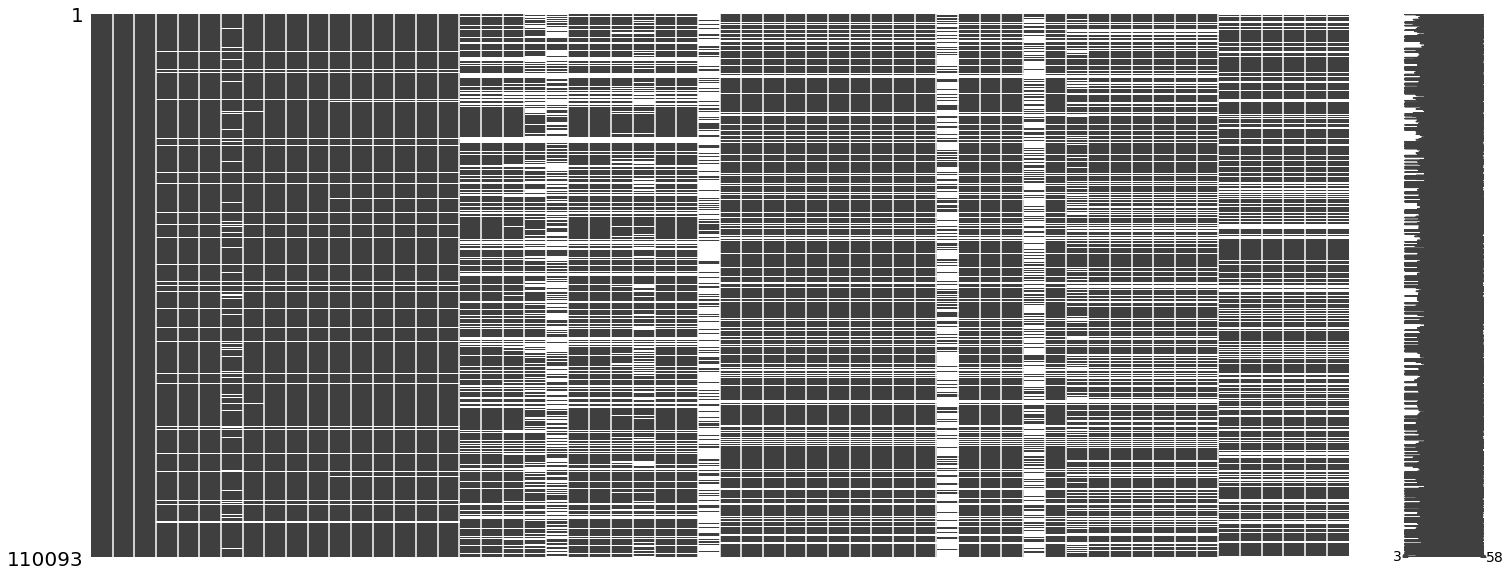

In [44]:
msno.matrix(df_train_merged)

In [45]:
df_train_merged.columns[df_train_merged.isnull().any()]

Index(['AMOUNT_ANNUITY_x', 'AMT_APPLICATION', 'AMOUNT_CREDIT_x',
       'AMOUNT_PAYMENT', 'AMOUNT_GOODS_PAYMENT', 'DAYS_DECISION',
       'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING',
       'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE',
       'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL', 'DAYS_CREDIT',
       'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT',
       'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE',
       'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY', 'GENDER', 'CHILDRENS',
       'TOTAL_SALARY', 'AMOUNT_CREDIT_y', 'AMOUNT_ANNUITY_y',
       'EDUCATION_LEVEL', 'FAMILY_STATUS', 'REGION_POPULATION', 'AGE',
       'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDI

In [46]:
df_test_merged.columns[df_test_merged.isnull().any()]


Index(['AMOUNT_ANNUITY_x', 'AMT_APPLICATION', 'AMOUNT_CREDIT_x',
       'AMOUNT_PAYMENT', 'AMOUNT_GOODS_PAYMENT', 'DAYS_DECISION',
       'SELLERPLACE_AREA', 'CNT_PAYMENT', 'DAYS_FIRST_DRAWING',
       'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION', 'DAYS_LAST_DUE',
       'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL', 'DAYS_CREDIT',
       'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT',
       'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG', 'AMT_CREDIT_SUM',
       'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT', 'AMT_CREDIT_SUM_OVERDUE',
       'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY', 'GENDER', 'CHILDRENS',
       'TOTAL_SALARY', 'AMOUNT_CREDIT_y', 'AMOUNT_ANNUITY_y',
       'EDUCATION_LEVEL', 'FAMILY_STATUS', 'REGION_POPULATION', 'AGE',
       'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE', 'FLAG_PHONE', 'FLAG_EMAIL',
       'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2',
       'EXTERNAL_SCORING_RATING_3', 'AMT_REQ_CREDIT_BUREAU_HOUR',
       'AMT_REQ_CREDI

In [47]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    print(f"Total NA-values = {na.sum()}")
    return result.T

In [48]:
check_missings(df_train_merged)

Total NA-values = 1352380


APPLICATION_NUMBER TARGET NAME_CONTRACT_TYPE AMOUNT_ANNUITY_x  \
Total                    0      0                  0             5576   
Percent                  0      0                  0          5.06481   
Types                int64  int64             object          float64   

        AMT_APPLICATION AMOUNT_CREDIT_x AMOUNT_PAYMENT AMOUNT_GOODS_PAYMENT  \
Total              5437            5437          11691                 5751   
Percent         4.93855         4.93855        10.6192              5.22377   
Types           float64         float64        float64              float64   

        DAYS_DECISION SELLERPLACE_AREA  ... AMT_REQ_CREDIT_BUREAU_WEEK  \
Total            5437             5437  ...                      32613   
Percent       4.93855          4.93855  ...                    29.6231   
Types         float64          float64  ...                    float64   

        AMT_REQ_CREDIT_BUREAU_MON AMT_REQ_CREDIT_BUREAU_QRT  \
Total                       32613                     32613   
Percent                   29.6231                   29.6231   
Types                     float64                   float64   

        AMT_REQ_CREDIT_BUREAU_YEAR NUM_INSTALMENT_VERSION  \
Total                        32613                  28126   
Percent                    29.6231                25.5475   
Types                      float64                float64   

        NUM_INSTALMENT_NUMBER DAYS_INSTALMENT DAYS_ENTRY_PAYMENT  \
Total                   28126           28126              28128   
Percent               25.5475         25.5475            25.5493   
Types                 float64         float64            float64   

        AMT_INSTALMENT AMT_PAYMENT  
Total            28126       28128  
Percent        25.5475     25.5493  
Types          float64     float64  

[3 rows x 58 columns]

In [49]:
check_missings(df_test_merged)

Total NA-values = 2035914


APPLICATION_NUMBER NAME_CONTRACT_TYPE AMOUNT_ANNUITY_x  \
Total                    0                  0             8270   
Percent                  0                  0          5.00784   
Types                int64             object          float64   

        AMT_APPLICATION AMOUNT_CREDIT_x AMOUNT_PAYMENT AMOUNT_GOODS_PAYMENT  \
Total              8057            8057          17325                 8540   
Percent         4.87886         4.87886         10.491              5.17134   
Types           float64         float64        float64              float64   

        DAYS_DECISION SELLERPLACE_AREA CNT_PAYMENT  ...  \
Total            8057             8057        8270  ...   
Percent       4.87886          4.87886     5.00784  ...   
Types         float64          float64     float64  ...   

        AMT_REQ_CREDIT_BUREAU_WEEK AMT_REQ_CREDIT_BUREAU_MON  \
Total                        49104                     49104   
Percent                    29.7346                   29.7346   
Types                      float64                   float64   

        AMT_REQ_CREDIT_BUREAU_QRT AMT_REQ_CREDIT_BUREAU_YEAR  \
Total                       49104                      49104   
Percent                   29.7346                    29.7346   
Types                     float64                    float64   

        NUM_INSTALMENT_VERSION NUM_INSTALMENT_NUMBER DAYS_INSTALMENT  \
Total                    42568                 42568           42568   
Percent                25.7768               25.7768         25.7768   
Types                  float64               float64         float64   

        DAYS_ENTRY_PAYMENT AMT_INSTALMENT AMT_PAYMENT  
Total                42574          42568       42574  
Percent            25.7804        25.7768     25.7804  
Types              float64        float64     float64  

[3 rows x 57 columns]

In [50]:
df_train_merged["TARGET"].unique()


array([0, 1], dtype=int64)

In [51]:
df_train_merged["TARGET"].value_counts()


0    101196
1      8897
Name: TARGET, dtype: int64

Целевое значение очень мало представлено, всего 9% процентов от общего количества

In [52]:
df_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110093 entries, 0 to 110092
Data columns (total 58 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          110093 non-null  int64  
 1   TARGET                      110093 non-null  int64  
 2   NAME_CONTRACT_TYPE          110093 non-null  object 
 3   AMOUNT_ANNUITY_x            104517 non-null  float64
 4   AMT_APPLICATION             104656 non-null  float64
 5   AMOUNT_CREDIT_x             104656 non-null  float64
 6   AMOUNT_PAYMENT              98402 non-null   float64
 7   AMOUNT_GOODS_PAYMENT        104342 non-null  float64
 8   DAYS_DECISION               104656 non-null  float64
 9   SELLERPLACE_AREA            104656 non-null  float64
 10  CNT_PAYMENT                 104518 non-null  float64
 11  DAYS_FIRST_DRAWING          104176 non-null  float64
 12  DAYS_FIRST_DUE              104176 non-null  float64
 13  DAYS_LAST_DUE_

In [53]:
df_test_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 165141 entries, 0 to 165140
Data columns (total 57 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   APPLICATION_NUMBER          165141 non-null  int64  
 1   NAME_CONTRACT_TYPE          165141 non-null  object 
 2   AMOUNT_ANNUITY_x            156871 non-null  float64
 3   AMT_APPLICATION             157084 non-null  float64
 4   AMOUNT_CREDIT_x             157084 non-null  float64
 5   AMOUNT_PAYMENT              147816 non-null  float64
 6   AMOUNT_GOODS_PAYMENT        156601 non-null  float64
 7   DAYS_DECISION               157084 non-null  float64
 8   SELLERPLACE_AREA            157084 non-null  float64
 9   CNT_PAYMENT                 156871 non-null  float64
 10  DAYS_FIRST_DRAWING          156403 non-null  float64
 11  DAYS_FIRST_DUE              156403 non-null  float64
 12  DAYS_LAST_DUE_1ST_VERSION   156403 non-null  float64
 13  DAYS_LAST_DUE 

Text(0, 0.5, 'count')

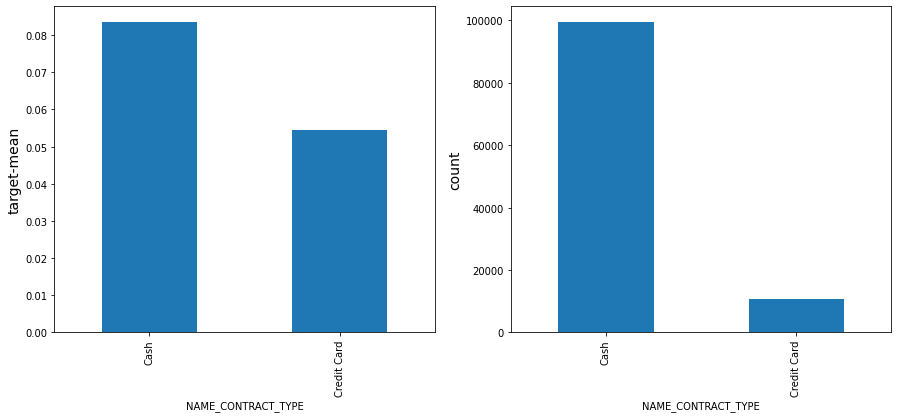

In [54]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df_train_merged.groupby(["NAME_CONTRACT_TYPE"])["TARGET"].mean().plot(kind="bar", ax=axes[0])
df_train_merged.groupby(["NAME_CONTRACT_TYPE"])["TARGET"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)

видим, что тип кредита cradit card имеет большую значимость, т.к. при меньшем количестве в среднем не сильно уступает наличным.

Text(0, 0.5, 'count')

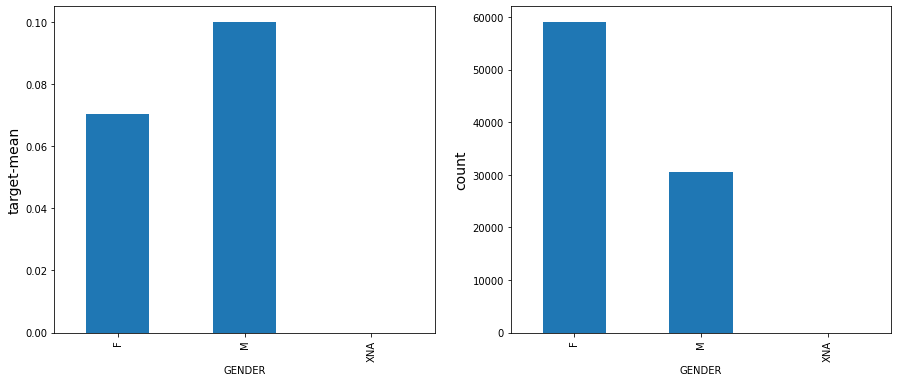

In [55]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df_train_merged.groupby(["GENDER"])["TARGET"].mean().plot(kind="bar", ax=axes[0])
df_train_merged.groupby(["GENDER"])["TARGET"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)

In [56]:
#в данных по полу есть третья графа, пустая. используем ее для пропусков
df_train_merged['GENDER'].fillna('XNA', inplace=True)


Text(0, 0.5, 'count')

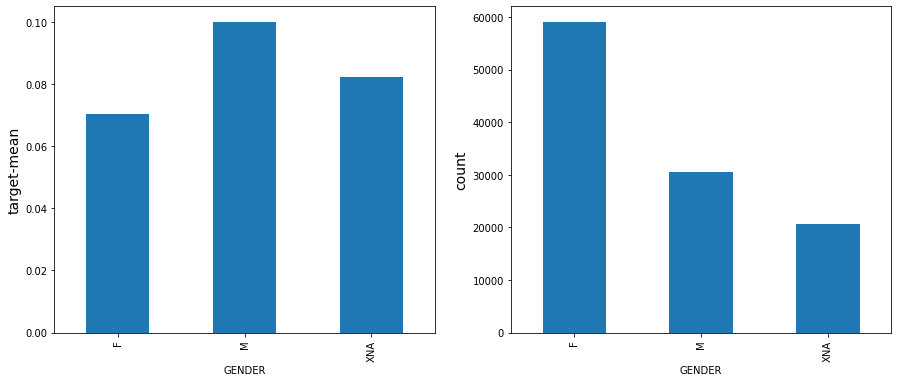

In [57]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df_train_merged.groupby(["GENDER"])["TARGET"].mean().plot(kind="bar", ax=axes[0])
df_train_merged.groupby(["GENDER"])["TARGET"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)

мужчин меньше, но они сильнее связаны с целевой переменной. При этом, мы видим, что количество пропусков также сильно связано с целевой переменной. Это означает, что либо это мужчины, либо в пропуски попали все связанные с целевым значением женщины

Text(0, 0.5, 'count')

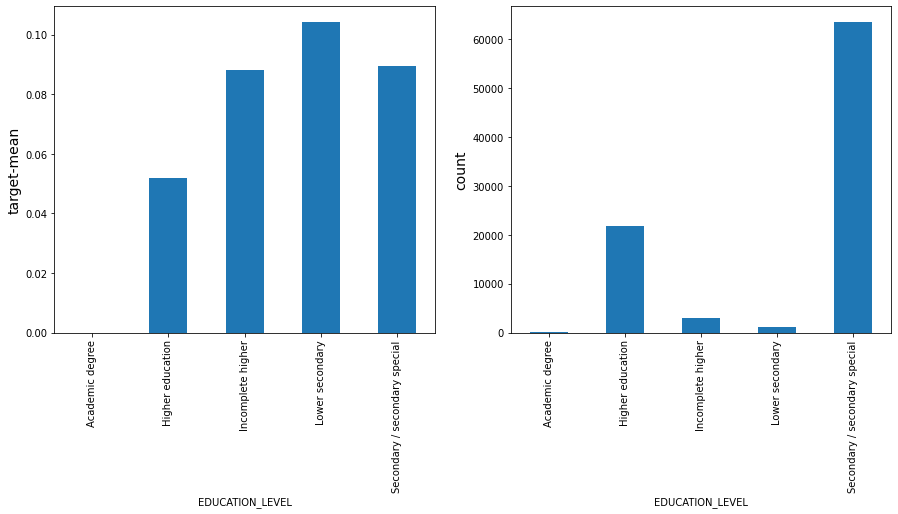

In [58]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df_train_merged.groupby(["EDUCATION_LEVEL"])["TARGET"].mean().plot(kind="bar", ax=axes[0])
df_train_merged.groupby(["EDUCATION_LEVEL"])["TARGET"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)


lower secondary и incomplete higher сильно выбиваются.

Text(0, 0.5, 'count')

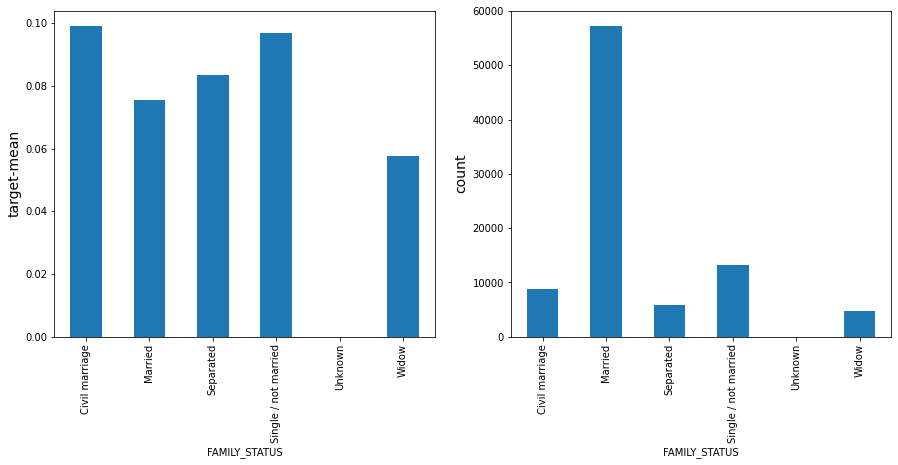

In [59]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
df_train_merged.groupby(["FAMILY_STATUS"])["TARGET"].mean().plot(kind="bar", ax=axes[0])
df_train_merged.groupby(["FAMILY_STATUS"])["TARGET"].size().plot(kind="bar", ax=axes[1])
axes[0].set_ylabel("target-mean", fontsize=14)
axes[1].set_ylabel("count", fontsize=14)


In [63]:
class FeatureImputer():
    """Заполнение пропусков"""
    
    def __init__(self):
        self.medians=None
        self.mins = None

    def fit(self, df):
        self.medians = df.median()
    
    def transform(self, df):
        #Обработка количественных признаков 
        df['FAMILY_STATUS'].fillna('Unknown', inplace=True)
        
        numerical_features = df.select_dtypes(include=[np.number])
        
        cat_features = df.select_dtypes(include = ['object'])

        for num in numerical_features:
            numerical_features.loc[(numerical_features[num].isnull(), [num])] = numerical_features[num].median()

        for cat in cat_features:
            cat_features.loc[(cat_features[cat].isnull(), [cat])] = df[cat].mode()[0]
                        
        for cat in cat_features:
            #enc = LabelEncoder()
            #cat_features[cat] = enc.fit_transform(cat_features[cat])
            cat_features = pd.concat([cat_features, pd.get_dummies(cat_features[cat], prefix=cat)], axis=1)
            
        #cat_features = cat_features.drop(['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], axis=1)
        df = pd.concat([numerical_features, cat_features], axis=1)
        
        df["DAYS_ON_LAST_JOB"] = df["DAYS_ON_LAST_JOB"].replace(365243, np.nan)
        bki_flags = [flag for flag in df.columns if "AMT_REQ_CREDIT_BUREAU" in flag]
        df["bki_requests_count"] = df[bki_flags].sum(axis=1)
        df["bki_kurtosis"] = df[bki_flags].kurtosis(axis=1)

        df["external_scoring_prod"] = df["EXTERNAL_SCORING_RATING_1"] * df["EXTERNAL_SCORING_RATING_2"] * df["EXTERNAL_SCORING_RATING_3"]
        df["external_scoring_weighted"] = df.EXTERNAL_SCORING_RATING_1 * 2 + df.EXTERNAL_SCORING_RATING_2 * 1 + df.EXTERNAL_SCORING_RATING_3 * 3

        for function_name in ["min", "max", "mean", "nanmedian", "var"]:
            feature_name = "EXTERNAL_SCORING_RATING_{}".format(function_name)
            df[feature_name] = eval("np.{}".format(function_name))(
                df[["EXTERNAL_SCORING_RATING_1", "EXTERNAL_SCORING_RATING_2", "EXTERNAL_SCORING_RATING_3"]], axis=1
            )

        # Отношение между основными фин. показателями
        df['ratio_credit_to_annuity'] = df['AMOUNT_CREDIT_y'] / df['AMOUNT_ANNUITY_y']
        df["ratio_annuity_to_salary"] = df['AMOUNT_ANNUITY_y'] / df['TOTAL_SALARY']
        df['ratio_credit_to_salary'] = df['AMOUNT_CREDIT_y'] / df['TOTAL_SALARY']
        df['ratio_salary_to_annuity'] = df['TOTAL_SALARY'] / df['AMOUNT_ANNUITY_y']

        
        # Отношение фин. показателей к возрасту и временным фичам
        df["ratio_annuity_to_age"] = df["AMOUNT_ANNUITY_y"] / df["AGE"]
        df["ratio_credit_to_age"] = df["AMOUNT_CREDIT_y"] / df["AGE"]
        df["ratio_salary_to_age"] = df["TOTAL_SALARY"] / df["AGE"]
        df["ratio_salary_to_experience"] = df["TOTAL_SALARY"] / df["DAYS_ON_LAST_JOB"]
        df["ratio_credit_to_experience"] = df["AMOUNT_CREDIT_y"] / df["DAYS_ON_LAST_JOB"]
        df["ratio_annuity_to_experience"] = df["AMOUNT_ANNUITY_y"] / df["DAYS_ON_LAST_JOB"]
        df['ratio_salary_to_family'] = df['TOTAL_SALARY'] / df['FAMILY_SIZE']


        # Отношение врменных признаков
        df["ratio_age_to_experience"] = df["AGE"] / df["DAYS_ON_LAST_JOB"]
        df["ratio_salary_to_region_population"] = df["TOTAL_SALARY"] * df["REGION_POPULATION"]
        df["ratio_car_to_experience"] = df["OWN_CAR_AGE"] / df["DAYS_ON_LAST_JOB"]
        df["ratio_car_to_age"] = df["OWN_CAR_AGE"] / df["AGE"]

        # Произведение фин. показателей кредита на вероятность дефолта
        # Такая штука называется математическим ожиданием дефолта или ожидаемыми потерями
        df["expected_total_loss_1"] = df["EXTERNAL_SCORING_RATING_1"] * df["AMOUNT_CREDIT_y"]
        df["expected_total_loss_2"] = df["EXTERNAL_SCORING_RATING_2"] * df["AMOUNT_CREDIT_y"]
        df["expected_total_loss_3"] = df["EXTERNAL_SCORING_RATING_3"] * df["AMOUNT_CREDIT_y"]
        df["expected_monthly_loss_1"] = df["EXTERNAL_SCORING_RATING_1"] * df["AMOUNT_ANNUITY_y"]
        df["expected_monthly_loss_2"] = df["EXTERNAL_SCORING_RATING_2"] * df["AMOUNT_ANNUITY_y"]
        df["expected_monthly_loss_3"] = df["EXTERNAL_SCORING_RATING_3"] * df["AMOUNT_ANNUITY_y"]
        
        pca = PCA(n_components=1)
        N_1 = pca.fit_transform(df.loc[:,['EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', "EXTERNAL_SCORING_RATING_3"]].values)
        pca.explained_variance_ratio_[:2].sum()

        df['N_1'] = N_1
        N_1 = pca.transform(df.loc[:,['EXTERNAL_SCORING_RATING_1', 'EXTERNAL_SCORING_RATING_2', "EXTERNAL_SCORING_RATING_3"]].values)


        pca = PCA(n_components=1)
        N_2 = pca.fit_transform(df.loc[:,['AMOUNT_ANNUITY_y', 'AMOUNT_CREDIT_y']].values)
        pca.explained_variance_ratio_[:2].sum()  

        df['N_2'] = N_2

        N_2 = pca.transform(df.loc[:,['AMOUNT_ANNUITY_y', 'AMOUNT_CREDIT_y']].values)
   
        return df

In [64]:
df_train_merged['Credit_card_man_XNA'] = 0
df_train_merged.loc[(df_train_merged['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df_train_merged['GENDER'] != 'F'), 'Credit_card_man_XNA'] = 1
                
df_train_merged['Credit_card_education'] = 0
df_train_merged.loc[(df_train_merged['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df_train_merged['EDUCATION_LEVEL'] == 'Lower secondary'), 'Credit_card_education'] = 1
df_train_merged.loc[(df_train_merged['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df_train_merged['EDUCATION_LEVEL'] == 'Incomplete higher'), 'Credit_card_education'] = 1
                
df_train_merged['Credit_card_marital'] = 1
df_train_merged.loc[(df_train_merged['NAME_CONTRACT_TYPE'] == 'Cash') | (df_train_merged['FAMILY_STATUS'] == 'Married'), 'Credit_card_marital'] = 0

In [65]:
df_test_merged['Credit_card_man_XNA'] = 0
df_test_merged.loc[(df_test_merged['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df_test_merged['GENDER'] != 'F'), 'Credit_card_man_XNA'] = 1
                
df_test_merged['Credit_card_education'] = 0
df_test_merged.loc[(df_test_merged['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df_test_merged['EDUCATION_LEVEL'] == 'Lower secondary'), 'Credit_card_education'] = 1
df_test_merged.loc[(df_test_merged['NAME_CONTRACT_TYPE'] == 'Credit Card') | (df_test_merged['EDUCATION_LEVEL'] == 'Incomplete higher'), 'Credit_card_education'] = 1
                
df_test_merged['Credit_card_marital'] = 1
df_test_merged.loc[(df_test_merged['NAME_CONTRACT_TYPE'] == 'Cash') | (df_test_merged['FAMILY_STATUS'] == 'Married'), 'Credit_card_marital'] = 0

In [66]:
df_train_merged.columns

Index(['APPLICATION_NUMBER', 'TARGET', 'AMOUNT_ANNUITY_x', 'AMT_APPLICATION',
       'AMOUNT_CREDIT_x', 'AMOUNT_PAYMENT', 'AMOUNT_GOODS_PAYMENT',
       'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT',
       'DAYS_FIRST_DRAWING', 'DAYS_FIRST_DUE', 'DAYS_LAST_DUE_1ST_VERSION',
       'DAYS_LAST_DUE', 'DAYS_TERMINATION', 'NFLAG_INSURED_ON_APPROVAL',
       'DAYS_CREDIT', 'CREDIT_DAY_OVERDUE', 'DAYS_CREDIT_ENDDATE',
       'DAYS_ENDDATE_FACT', 'AMT_CREDIT_MAX_OVERDUE', 'CNT_CREDIT_PROLONG',
       'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_LIMIT',
       'AMT_CREDIT_SUM_OVERDUE', 'DAYS_CREDIT_UPDATE', 'AMT_ANNUITY',
       'CHILDRENS', 'TOTAL_SALARY', 'AMOUNT_CREDIT_y', 'AMOUNT_ANNUITY_y',
       'REGION_POPULATION', 'AGE', 'DAYS_ON_LAST_JOB', 'OWN_CAR_AGE',
       'FLAG_PHONE', 'FLAG_EMAIL', 'FAMILY_SIZE', 'EXTERNAL_SCORING_RATING_1',
       'EXTERNAL_SCORING_RATING_2', 'EXTERNAL_SCORING_RATING_3',
       'AMT_REQ_CREDIT_BUREAU_HOUR', 'AMT_REQ_CREDIT_BUREAU_DAY',
      

In [67]:
imputer = FeatureImputer()

imputer.fit(df_train_merged)

df_train_merged = imputer.transform(df_train_merged)
df_test_merged = imputer.transform(df_test_merged)

In [68]:
df_train_merged = df_train_merged.drop(['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], axis=1)
df_test_merged = df_test_merged.drop(['NAME_CONTRACT_TYPE', 'GENDER', 'EDUCATION_LEVEL', 'FAMILY_STATUS'], axis=1)

In [71]:
numerical_features = df_train_merged.select_dtypes(include=[np.number])
numerical_features
features = numerical_features.columns.tolist()


In [72]:
features

['APPLICATION_NUMBER',
 'TARGET',
 'AMOUNT_ANNUITY_x',
 'AMT_APPLICATION',
 'AMOUNT_CREDIT_x',
 'AMOUNT_PAYMENT',
 'AMOUNT_GOODS_PAYMENT',
 'DAYS_DECISION',
 'SELLERPLACE_AREA',
 'CNT_PAYMENT',
 'DAYS_FIRST_DRAWING',
 'DAYS_FIRST_DUE',
 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_LAST_DUE',
 'DAYS_TERMINATION',
 'NFLAG_INSURED_ON_APPROVAL',
 'DAYS_CREDIT',
 'CREDIT_DAY_OVERDUE',
 'DAYS_CREDIT_ENDDATE',
 'DAYS_ENDDATE_FACT',
 'AMT_CREDIT_MAX_OVERDUE',
 'CNT_CREDIT_PROLONG',
 'AMT_CREDIT_SUM',
 'AMT_CREDIT_SUM_DEBT',
 'AMT_CREDIT_SUM_LIMIT',
 'AMT_CREDIT_SUM_OVERDUE',
 'DAYS_CREDIT_UPDATE',
 'AMT_ANNUITY',
 'CHILDRENS',
 'TOTAL_SALARY',
 'AMOUNT_CREDIT_y',
 'AMOUNT_ANNUITY_y',
 'REGION_POPULATION',
 'AGE',
 'DAYS_ON_LAST_JOB',
 'OWN_CAR_AGE',
 'FLAG_PHONE',
 'FLAG_EMAIL',
 'FAMILY_SIZE',
 'EXTERNAL_SCORING_RATING_1',
 'EXTERNAL_SCORING_RATING_2',
 'EXTERNAL_SCORING_RATING_3',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'AMT_REQ_CREDIT_BUREAU_MON',

In [74]:
df_train_merged.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 110093 entries, 0 to 110092
Columns: 105 entries, APPLICATION_NUMBER to N_2
dtypes: float64(84), int64(5), uint8(16)
memory usage: 77.3 MB


In [76]:
correlation = df_train_merged.corr()
corr_with_target = correlation["TARGET"].sort_values(ascending = False)
corr_with_target

TARGET                                           1.000000
N_1                                              0.186778
EXTERNAL_SCORING_RATING_var                      0.061397
EDUCATION_LEVEL_Secondary / secondary special    0.045948
GENDER_M                                         0.043532
                                                   ...   
EXTERNAL_SCORING_RATING_min                     -0.162035
external_scoring_prod                           -0.170404
EXTERNAL_SCORING_RATING_nanmedian               -0.173989
external_scoring_weighted                       -0.187810
EXTERNAL_SCORING_RATING_mean                    -0.199136
Name: TARGET, Length: 105, dtype: float64

In [77]:
def lightgbm_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    if not categorical:
        categorical = "auto"

    estimators, folds_scores = [], []
    oof_preds = np.zeros(X.shape[0])
    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):
        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]

        model = lgb.LGBMClassifier(**params)
        model.fit(
            x_train, y_train,
            eval_set=[(x_valid, y_valid)],
            eval_metric="auc", verbose=50, early_stopping_rounds=500,
            categorical_feature=categorical
        )
        oof_preds[valid_idx] = model.predict_proba(x_valid)[:, 1]
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        folds_scores.append(round(score, 5))
        estimators.append(model)

    print(f"Score by each fold: {folds_scores}")
    print("="*65)
    return estimators, oof_preds



In [78]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}

cv = KFold(n_splits=7, random_state=435, shuffle=True)
target, df_train_merged = df_train_merged["TARGET"], df_train_merged.drop(["TARGET"], axis=1)

In [79]:
estimators, oof_preds_lgbm = lightgbm_cross_validation(
    lgbm_params, df_train_merged, target, cv
)

Tue Dec 22 19:03:39 2020, Cross-Validation, 110093 rows, 104 cols
Training until validation scores don't improve for 500 rounds
[50]	valid_0's auc: 0.725157	valid_0's binary_logloss: 0.270581
[100]	valid_0's auc: 0.726024	valid_0's binary_logloss: 0.264556
[150]	valid_0's auc: 0.726506	valid_0's binary_logloss: 0.260857
[200]	valid_0's auc: 0.727503	valid_0's binary_logloss: 0.258353
[250]	valid_0's auc: 0.728954	valid_0's binary_logloss: 0.25654
[300]	valid_0's auc: 0.729848	valid_0's binary_logloss: 0.255294
[350]	valid_0's auc: 0.730605	valid_0's binary_logloss: 0.254421
[400]	valid_0's auc: 0.731807	valid_0's binary_logloss: 0.253643
[450]	valid_0's auc: 0.733599	valid_0's binary_logloss: 0.252939
[500]	valid_0's auc: 0.735239	valid_0's binary_logloss: 0.252339
[550]	valid_0's auc: 0.736295	valid_0's binary_logloss: 0.251806
[600]	valid_0's auc: 0.737108	valid_0's binary_logloss: 0.251395
[650]	valid_0's auc: 0.738304	valid_0's binary_logloss: 0.251028
[700]	valid_0's auc: 0.7389	v

[1800]	valid_0's auc: 0.731465	valid_0's binary_logloss: 0.258644
[1850]	valid_0's auc: 0.731431	valid_0's binary_logloss: 0.258692
Early stopping, best iteration is:
[1377]	valid_0's auc: 0.731841	valid_0's binary_logloss: 0.258564
Fold 3, Valid score = 0.73184
Training until validation scores don't improve for 500 rounds
[50]	valid_0's auc: 0.697549	valid_0's binary_logloss: 0.270149
[100]	valid_0's auc: 0.699156	valid_0's binary_logloss: 0.265359
[150]	valid_0's auc: 0.699835	valid_0's binary_logloss: 0.262441
[200]	valid_0's auc: 0.701046	valid_0's binary_logloss: 0.260501
[250]	valid_0's auc: 0.701665	valid_0's binary_logloss: 0.25922
[300]	valid_0's auc: 0.703199	valid_0's binary_logloss: 0.258293
[350]	valid_0's auc: 0.7042	valid_0's binary_logloss: 0.257691
[400]	valid_0's auc: 0.705009	valid_0's binary_logloss: 0.257264
[450]	valid_0's auc: 0.706117	valid_0's binary_logloss: 0.256883
[500]	valid_0's auc: 0.707138	valid_0's binary_logloss: 0.256546
[550]	valid_0's auc: 0.707864

[1700]	valid_0's auc: 0.712319	valid_0's binary_logloss: 0.258043
[1750]	valid_0's auc: 0.712329	valid_0's binary_logloss: 0.258032
[1800]	valid_0's auc: 0.712258	valid_0's binary_logloss: 0.258061
[1850]	valid_0's auc: 0.712231	valid_0's binary_logloss: 0.258083
[1900]	valid_0's auc: 0.712246	valid_0's binary_logloss: 0.258112
[1950]	valid_0's auc: 0.712312	valid_0's binary_logloss: 0.258111
[2000]	valid_0's auc: 0.712186	valid_0's binary_logloss: 0.25814
[2050]	valid_0's auc: 0.712189	valid_0's binary_logloss: 0.258134
[2100]	valid_0's auc: 0.712246	valid_0's binary_logloss: 0.258133
[2150]	valid_0's auc: 0.712182	valid_0's binary_logloss: 0.258161
[2200]	valid_0's auc: 0.712253	valid_0's binary_logloss: 0.25816
[2250]	valid_0's auc: 0.71234	valid_0's binary_logloss: 0.258146
Early stopping, best iteration is:
[1750]	valid_0's auc: 0.712329	valid_0's binary_logloss: 0.258032
Fold 6, Valid score = 0.71233
Training until validation scores don't improve for 500 rounds
[50]	valid_0's auc

In [80]:
score = roc_auc_score(target, oof_preds_lgbm)
print(f"Score = {round(score, 4)}")

Score = 0.7263


In [81]:
categorial = df_train_merged.dtypes[df_train_merged.dtypes == "object"].index
numerical = list(set(df_train_merged.columns) - set(categorial))

y_pred1 = np.zeros(df_test_merged.shape[0])
df_test_merged[numerical] = df_test_merged[numerical].astype(float)
df_test_merged[categorial] = df_test_merged[categorial].astype(str)

for estimator in estimators:
    y_pred1 += estimator.predict_proba(df_test_merged)[:, 1]


In [82]:
test_id = df_test["APPLICATION_NUMBER"]

y_pred1 = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred1 / cv.n_splits
})

In [83]:
x_train, x_valid = train_test_split(
    df_train_merged.drop(["APPLICATION_NUMBER"], axis=1), train_size=0.7, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.7, random_state=1
)

In [84]:
params = {
    'boosting_type': 'gbdt',
    'n_estimators': 10000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}
model = lgb.LGBMClassifier(**params)
model.fit(
        x_train, y_train,
        eval_set=[(x_valid, y_valid)],
        eval_metric="auc", verbose=50, early_stopping_rounds=500
        )

Training until validation scores don't improve for 500 rounds
[50]	valid_0's auc: 0.712781	valid_0's binary_logloss: 0.273741
[100]	valid_0's auc: 0.714837	valid_0's binary_logloss: 0.268217
[150]	valid_0's auc: 0.715446	valid_0's binary_logloss: 0.264823
[200]	valid_0's auc: 0.716462	valid_0's binary_logloss: 0.262599
[250]	valid_0's auc: 0.718234	valid_0's binary_logloss: 0.26099
[300]	valid_0's auc: 0.719136	valid_0's binary_logloss: 0.259883
[350]	valid_0's auc: 0.720385	valid_0's binary_logloss: 0.259135
[400]	valid_0's auc: 0.7207	valid_0's binary_logloss: 0.258591
[450]	valid_0's auc: 0.721233	valid_0's binary_logloss: 0.25811
[500]	valid_0's auc: 0.721957	valid_0's binary_logloss: 0.257727
[550]	valid_0's auc: 0.722537	valid_0's binary_logloss: 0.257421
[600]	valid_0's auc: 0.723061	valid_0's binary_logloss: 0.257186
[650]	valid_0's auc: 0.723729	valid_0's binary_logloss: 0.256986
[700]	valid_0's auc: 0.724446	valid_0's binary_logloss: 0.256824
[750]	valid_0's auc: 0.724916	val

LGBMClassifier(colsample_bytree=0.508716, is_unbalance=False,
               learning_rate=0.005134, max_depth=10, min_split_gain=0.024766,
               n_estimators=10000, num_leaves=54, random_state=42,
               reg_alpha=0.436193, reg_lambda=0.479169, silent=-1,
               subsample=0.7, subsample_for_bin=240000, verbose=-1)

In [85]:
from copy import deepcopy

lgb_params = deepcopy(params)
lgb_params["n_estimators"] = 100

model = lgb.LGBMClassifier(**params)
model.fit(x_train, y_train)

LGBMClassifier(colsample_bytree=0.508716, is_unbalance=False,
               learning_rate=0.005134, max_depth=10, min_split_gain=0.024766,
               n_estimators=10000, num_leaves=54, random_state=42,
               reg_alpha=0.436193, reg_lambda=0.479169, silent=-1,
               subsample=0.7, subsample_for_bin=240000, verbose=-1)

In [86]:
y_score = model.predict_proba(x_valid)[:, 1]
score = roc_auc_score(y_valid, y_score)

print(f"Valid score = {round(score, 4)}")

Valid score = 0.7139


In [87]:
x_valid_, y_valid_ = x_valid.sample(5000), y_valid.sample(5000)

explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_valid_, y_valid_)


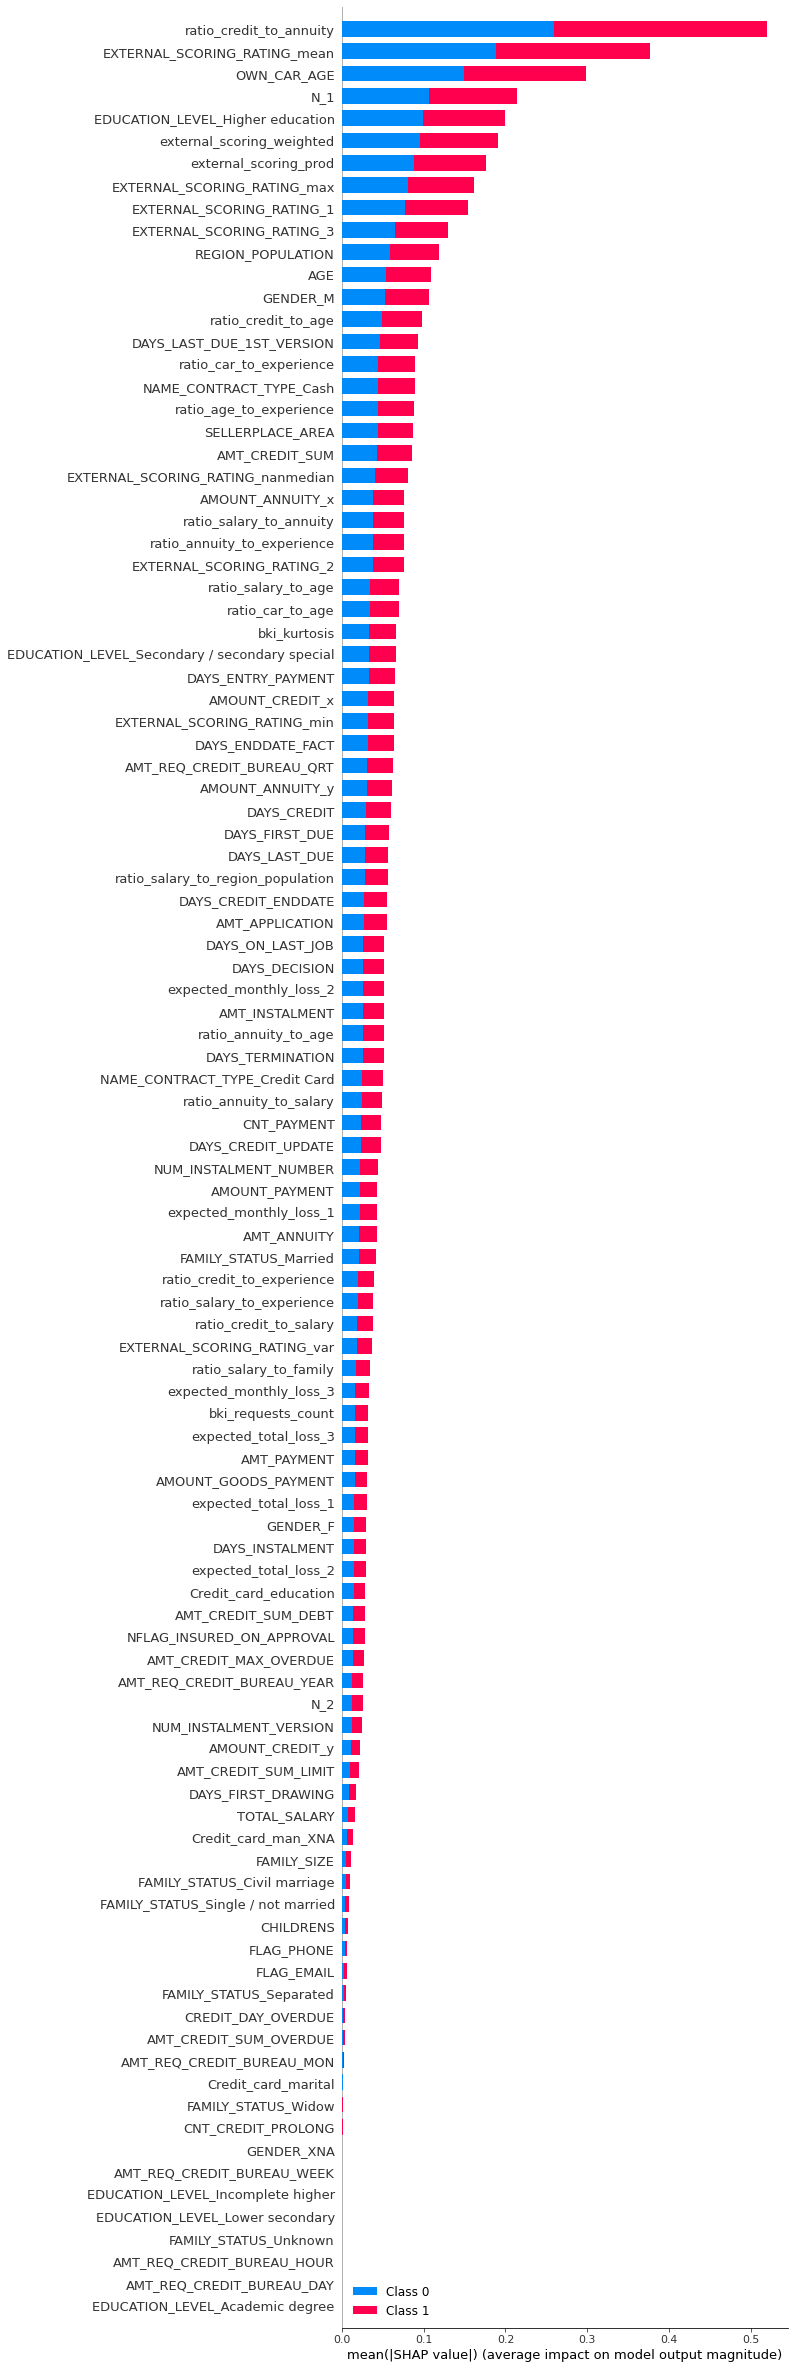

In [88]:
shap.summary_plot(shap_values, x_valid, plot_type="bar", max_display=x_valid.shape[1])

In [89]:
df_train_merged.columns


Index(['APPLICATION_NUMBER', 'AMOUNT_ANNUITY_x', 'AMT_APPLICATION',
       'AMOUNT_CREDIT_x', 'AMOUNT_PAYMENT', 'AMOUNT_GOODS_PAYMENT',
       'DAYS_DECISION', 'SELLERPLACE_AREA', 'CNT_PAYMENT',
       'DAYS_FIRST_DRAWING',
       ...
       'ratio_car_to_experience', 'ratio_car_to_age', 'expected_total_loss_1',
       'expected_total_loss_2', 'expected_total_loss_3',
       'expected_monthly_loss_1', 'expected_monthly_loss_2',
       'expected_monthly_loss_3', 'N_1', 'N_2'],
      dtype='object', length=104)

In [114]:
to_drop2 = ['EDUCATION_LEVEL_Academic degree',  'AMT_REQ_CREDIT_BUREAU_DAY', 'AMT_REQ_CREDIT_BUREAU_WEEK', 'GENDER_XNA', 'AMT_REQ_CREDIT_BUREAU_HOUR', 'EDUCATION_LEVEL_Lower secondary', 'FAMILY_STATUS_Unknown', 'EDUCATION_LEVEL_Incomplete higher', 'CNT_CREDIT_PROLONG','FAMILY_STATUS_Widow', 'FLAG_EMAIL', 'AMT_REQ_CREDIT_BUREAU_MON', 'CREDIT_DAY_OVERDUE', 'AMT_CREDIT_SUM_OVERDUE', 'FAMILY_STATUS_Separated', 'CHILDRENS', 'FAMILY_STATUS_Civil marriage', 'FAMILY_STATUS_Single / not married', 'FLAG_PHONE', 'FAMILY_SIZE', 'DAYS_FIRST_DRAWING', 'TOTAL_SALARY', 'AMT_CREDIT_SUM_LIMIT', 'NUM_INSTALMENT_VERSION', 'AMT_CREDIT_MAX_OVERDUE', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'expected_total_loss_1', 'NFLAG_INSURED_ON_APPROVAL', 'AMT_PAYMENT', 'AMOUNT_CREDIT_y', 'ratio_credit_to_salary', 'expected_total_loss_2', 'AMT_CREDIT_SUM_DEBT', 'DAYS_INSTALMENT', 'bki_requests_count', 'expected_total_loss_3', 'AMOUNT_GOODS_PAYMENT',  'expected_monthly_loss_3', 'ratio_credit_to_experience', 'AMT_ANNUITY', 'GENDER_F']
to_drop2

to_drop3 = list(pd.DataFrame({'name': x_valid.columns, 'importance': np.mean(np.abs(shap_values), axis=0)}
                              ).sort_values(by='importance', ascending=False).reset_index(drop=True).tail(60)['name'])
to_drop3

['EDUCATION_LEVEL_Academic degree',
 'AMT_REQ_CREDIT_BUREAU_DAY',
 'AMT_REQ_CREDIT_BUREAU_WEEK',
 'GENDER_XNA',
 'AMT_REQ_CREDIT_BUREAU_HOUR',
 'EDUCATION_LEVEL_Lower secondary',
 'FAMILY_STATUS_Unknown',
 'EDUCATION_LEVEL_Incomplete higher',
 'CNT_CREDIT_PROLONG',
 'FAMILY_STATUS_Widow',
 'FLAG_EMAIL',
 'AMT_REQ_CREDIT_BUREAU_MON',
 'CREDIT_DAY_OVERDUE',
 'AMT_CREDIT_SUM_OVERDUE',
 'FAMILY_STATUS_Separated',
 'CHILDRENS',
 'FAMILY_STATUS_Civil marriage',
 'FAMILY_STATUS_Single / not married',
 'FLAG_PHONE',
 'FAMILY_SIZE',
 'DAYS_FIRST_DRAWING',
 'TOTAL_SALARY',
 'AMT_CREDIT_SUM_LIMIT',
 'NUM_INSTALMENT_VERSION',
 'AMT_CREDIT_MAX_OVERDUE',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'expected_total_loss_1',
 'NFLAG_INSURED_ON_APPROVAL',
 'AMT_PAYMENT',
 'AMOUNT_CREDIT_y',
 'ratio_credit_to_salary',
 'expected_total_loss_2',
 'AMT_CREDIT_SUM_DEBT',
 'DAYS_INSTALMENT',
 'bki_requests_count',
 'expected_total_loss_3',
 'AMOUNT_GOODS_PAYMENT',
 'expected_monthly_loss_3',
 'ratio_credit_to_experience'

In [91]:
x_train_shap = x_train.drop(to_drop2, axis=1)
x_valid_shap = x_valid.drop(to_drop2, axis=1)

In [92]:
model = lgb.LGBMClassifier(**params)
model.fit(
        x_train_shap, y_train,
        eval_set=[(x_valid_shap, y_valid)],
        eval_metric="auc", verbose=50, early_stopping_rounds=500
        )

Training until validation scores don't improve for 500 rounds
[50]	valid_0's auc: 0.713	valid_0's binary_logloss: 0.273626
[100]	valid_0's auc: 0.71345	valid_0's binary_logloss: 0.268149
[150]	valid_0's auc: 0.715192	valid_0's binary_logloss: 0.264735
[200]	valid_0's auc: 0.716758	valid_0's binary_logloss: 0.262448
[250]	valid_0's auc: 0.718001	valid_0's binary_logloss: 0.260896
[300]	valid_0's auc: 0.718799	valid_0's binary_logloss: 0.259846
[350]	valid_0's auc: 0.719859	valid_0's binary_logloss: 0.259133
[400]	valid_0's auc: 0.720441	valid_0's binary_logloss: 0.258585
[450]	valid_0's auc: 0.721397	valid_0's binary_logloss: 0.258117
[500]	valid_0's auc: 0.722275	valid_0's binary_logloss: 0.257718
[550]	valid_0's auc: 0.723009	valid_0's binary_logloss: 0.257438
[600]	valid_0's auc: 0.723504	valid_0's binary_logloss: 0.257172
[650]	valid_0's auc: 0.723927	valid_0's binary_logloss: 0.256961
[700]	valid_0's auc: 0.724452	valid_0's binary_logloss: 0.256754
[750]	valid_0's auc: 0.724749	val

LGBMClassifier(colsample_bytree=0.508716, is_unbalance=False,
               learning_rate=0.005134, max_depth=10, min_split_gain=0.024766,
               n_estimators=10000, num_leaves=54, random_state=42,
               reg_alpha=0.436193, reg_lambda=0.479169, silent=-1,
               subsample=0.7, subsample_for_bin=240000, verbose=-1)

In [93]:
df_train_shap = df_train_merged.drop(to_drop2, axis=1)
df_test_shap = df_test_merged.drop(to_drop2, axis=1)



In [94]:
lgbm_params = {
    'boosting_type': 'gbdt',
    'n_estimators': 5000,
    'learning_rate': 0.005134,
    'num_leaves': 54,
    'max_depth': 10,
    'subsample_for_bin': 240000,
    'reg_alpha': 0.436193,
    'reg_lambda': 0.479169,
    'colsample_bytree': 0.508716,
    'min_split_gain': 0.024766,
    'subsample': 0.7,
    'is_unbalance': False,
    'random_state': 42,
    'silent': -1,
    'verbose': -1
}

cv = KFold(n_splits=7, random_state=435, shuffle=True)
#target, target, df_train_shap

In [95]:
estimators, oof_preds_lgbm = lightgbm_cross_validation(
    lgbm_params, df_train_shap, target, cv
)

Tue Dec 22 19:12:53 2020, Cross-Validation, 110093 rows, 63 cols
Training until validation scores don't improve for 500 rounds
[50]	valid_0's auc: 0.724596	valid_0's binary_logloss: 0.270494
[100]	valid_0's auc: 0.725665	valid_0's binary_logloss: 0.264477
[150]	valid_0's auc: 0.726366	valid_0's binary_logloss: 0.260768
[200]	valid_0's auc: 0.72773	valid_0's binary_logloss: 0.258263
[250]	valid_0's auc: 0.728634	valid_0's binary_logloss: 0.256465
[300]	valid_0's auc: 0.730458	valid_0's binary_logloss: 0.255128
[350]	valid_0's auc: 0.731983	valid_0's binary_logloss: 0.254122
[400]	valid_0's auc: 0.733872	valid_0's binary_logloss: 0.253326
[450]	valid_0's auc: 0.735326	valid_0's binary_logloss: 0.252687
[500]	valid_0's auc: 0.736941	valid_0's binary_logloss: 0.252091
[550]	valid_0's auc: 0.738288	valid_0's binary_logloss: 0.251533
[600]	valid_0's auc: 0.739391	valid_0's binary_logloss: 0.251109
[650]	valid_0's auc: 0.739924	valid_0's binary_logloss: 0.25079
[700]	valid_0's auc: 0.740606	v

[1650]	valid_0's auc: 0.733885	valid_0's binary_logloss: 0.258247
[1700]	valid_0's auc: 0.733924	valid_0's binary_logloss: 0.25825
[1750]	valid_0's auc: 0.733842	valid_0's binary_logloss: 0.258273
Early stopping, best iteration is:
[1266]	valid_0's auc: 0.734035	valid_0's binary_logloss: 0.258201
Fold 3, Valid score = 0.73404
Training until validation scores don't improve for 500 rounds
[50]	valid_0's auc: 0.698201	valid_0's binary_logloss: 0.270051
[100]	valid_0's auc: 0.697917	valid_0's binary_logloss: 0.265271
[150]	valid_0's auc: 0.699779	valid_0's binary_logloss: 0.262364
[200]	valid_0's auc: 0.700545	valid_0's binary_logloss: 0.260433
[250]	valid_0's auc: 0.70141	valid_0's binary_logloss: 0.259132
[300]	valid_0's auc: 0.702367	valid_0's binary_logloss: 0.258247
[350]	valid_0's auc: 0.703412	valid_0's binary_logloss: 0.257588
[400]	valid_0's auc: 0.704831	valid_0's binary_logloss: 0.25712
[450]	valid_0's auc: 0.705661	valid_0's binary_logloss: 0.25677
[500]	valid_0's auc: 0.706857

[550]	valid_0's auc: 0.707242	valid_0's binary_logloss: 0.259138
[600]	valid_0's auc: 0.708059	valid_0's binary_logloss: 0.258861
[650]	valid_0's auc: 0.708646	valid_0's binary_logloss: 0.258669
[700]	valid_0's auc: 0.70926	valid_0's binary_logloss: 0.25849
[750]	valid_0's auc: 0.709758	valid_0's binary_logloss: 0.258401
[800]	valid_0's auc: 0.709876	valid_0's binary_logloss: 0.258351
[850]	valid_0's auc: 0.710078	valid_0's binary_logloss: 0.25833
[900]	valid_0's auc: 0.710202	valid_0's binary_logloss: 0.258334
[950]	valid_0's auc: 0.710558	valid_0's binary_logloss: 0.258283
[1000]	valid_0's auc: 0.710745	valid_0's binary_logloss: 0.258235
[1050]	valid_0's auc: 0.71088	valid_0's binary_logloss: 0.258246
[1100]	valid_0's auc: 0.711192	valid_0's binary_logloss: 0.258195
[1150]	valid_0's auc: 0.711245	valid_0's binary_logloss: 0.258196
[1200]	valid_0's auc: 0.711414	valid_0's binary_logloss: 0.258162
[1250]	valid_0's auc: 0.711491	valid_0's binary_logloss: 0.258159
[1300]	valid_0's auc: 0

In [96]:
score = roc_auc_score(target, oof_preds_lgbm)
print(f"Score = {round(score, 4)}")

Score = 0.7277


In [97]:
categorial = df_train_shap.dtypes[df_train_shap.dtypes == "object"].index
numerical = list(set(df_train_shap.columns) - set(categorial))

y_pred2 = np.zeros(df_test_shap.shape[0])
df_test_shap[numerical] = df_test_shap[numerical].astype(float)
df_test_shap[categorial] = df_test_shap[categorial].astype(str)

for estimator in estimators:
    y_pred2 += estimator.predict_proba(df_test_shap)[:, 1]
    
test_id = df_test["APPLICATION_NUMBER"]

y_pred2 = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred2 / cv.n_splits
})

In [98]:
def xgboost_cross_validation(params, X, y, cv, categorical = None):
    """
    Кросс-валидация для модели catbooost.

    Parameters
    ----------
    params: dict
        Словарь гиперпараметров модели.

    X: pandas.core.frame.DataFrame
        Матрица признако для обучения модели.

    y: pandas.core.frame.Series
        Вектор целевой переменной для обучения модели.

    cv: KFold or StratifiedKFold generator.
        Объект KFold / StratifiedKFold для определения
        стратегии кросс-валидации модели.

    categorical: str, optional, default = None
        Список категориальных признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    estimators: list
        Список с объектами обученной модели.

    encoders: dict
        Список с объектами LabelEncoders.

    oof_preds: np.array
        Вектор OOF-прогнозов.

    """
    estimators, encoders = [], {}
    oof_preds = np.zeros(X.shape[0])

    if categorical:
        for feature in categorical:
            encoder = LabelEncoder()
            X[feature] = encoder.fit_transform(X[feature].astype("str").fillna("NA"))
            encoders[feature] = encoder

    print(f"{time.ctime()}, Cross-Validation, {X.shape[0]} rows, {X.shape[1]} cols")

    for fold, (train_idx, valid_idx) in enumerate(cv.split(X, y)):

        x_train, x_valid = X.loc[train_idx], X.loc[valid_idx]
        y_train, y_valid = y[train_idx], y[valid_idx]
        dtrain = xgb.DMatrix(x_train, y_train)
        dvalid = xgb.DMatrix(x_valid, y_valid)

        model = xgb.train(
            params=params,
            dtrain=dtrain,
            maximize=True,
            num_boost_round=10000,
            early_stopping_rounds=25,
            evals=[(dtrain, "train"), (dvalid, "valid")],
            verbose_eval=10,
        )
        oof_preds[valid_idx] = model.predict(dvalid)
        score = roc_auc_score(y_valid, oof_preds[valid_idx])
        print(f"Fold {fold+1}, Valid score = {round(score, 5)}")
        estimators.append(model)

    return estimators, encoders, oof_preds

In [99]:
xgb_params = {
    "objective": "binary:logistic",
    "booster": "gbtree",
    "eval_metric": "auc",
    "eta": "0.05",
    "max_depth": 6,
    "gamma": 10,
    "subsample": 0.85,
    "colsample_bytree": 0.7,
    "colsample_bylevel": 0.632,
    "min_child_weight": 30,
    "alpha": 0,
    "lambda": 0,
    "nthread": 6,
    "random_seed": 42
}

xgb_cv = KFold(n_splits=10, random_state=42, shuffle=True)

In [100]:
xgb_estimators, _, xgb_oof = xgboost_cross_validation(
    xgb_params, df_train_merged, target, xgb_cv
)

Tue Dec 22 19:16:30 2020, Cross-Validation, 110093 rows, 104 cols
[19:16:31] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.69167	valid-auc:0.70374
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[10]	train-auc:0.70828	valid-auc:0.72240
[20]	train-auc:0.71157	valid-auc:0.72489
[30]	train-auc:0.71417	valid-auc:0.72604
[40]	train-auc:0.71764	valid-auc:0.72772
[50]	train-auc:0.72073	valid-auc:0.73125
[60]	train-auc:0.72562	valid-auc:0.73282
[70]	train-auc:0.73054	valid-auc:0.73531
[80]	train-auc:0.73475	valid-auc:0.73685
[90]	train-auc:0.73774	valid-auc:0

[0]	train-auc:0.69177	valid-auc:0.68606
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[10]	train-auc:0.71124	valid-auc:0.69847
[20]	train-auc:0.71327	valid-auc:0.70062
[30]	train-auc:0.71593	valid-auc:0.70141
[40]	train-auc:0.71910	valid-auc:0.70359
[50]	train-auc:0.72226	valid-auc:0.70590
[60]	train-auc:0.72643	valid-auc:0.70869
[70]	train-auc:0.73106	valid-auc:0.71144
[80]	train-auc:0.73489	valid-auc:0.71373
[90]	train-auc:0.73815	valid-auc:0.71440
[100]	train-auc:0.74041	valid-auc:0.71555
[110]	train-auc:0.74333	valid-auc:0.71658
[120]	train-auc:0.74681	valid-auc:0.71892
[130]	train-auc:0.74947	valid-auc:0.71886
[140]	train-auc:0.75100	valid-auc:0.71955
[150]	train-auc:0.75337	valid-auc:0.71971
[160]	train-auc:0.75499	valid-auc:0.72041
[170]	train-auc:0.75667	valid-auc:0.72073
[180]	train-auc:0.75831	valid-auc:0.72101
[190]	train-auc:0.76003	valid-auc:0.72123
[200]	train-auc:0.76103	vali

In [101]:
score = roc_auc_score(target, xgb_oof)
print(f"Score = {round(score, 4)}")

Score = 0.7259


In [102]:
scores = pd.DataFrame({
    "lgbm_numerical": oof_preds_lgbm,
    "xgb_numerical": xgb_oof,
    
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

<AxesSubplot:>

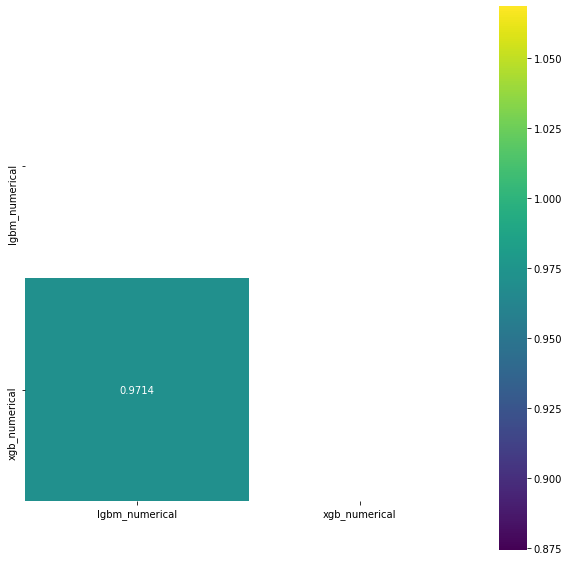

In [103]:
fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)

In [104]:
y_pred_xgb = np.zeros(df_test_merged.shape[0])
dtest = xgb.DMatrix(data=df_test_merged)

for estimator in xgb_estimators:
    y_pred_xgb += estimator.predict(dtest)
    
y_pred_xgb = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred_xgb / cv.n_splits
})

In [105]:
x_train, x_valid = train_test_split(
    df_train_merged, train_size=0.7, random_state=1
)
y_train, y_valid = train_test_split(
    target, train_size=0.7, random_state=1
)

In [106]:
params = {
    "booster": "gbtree",
    "objective": "binary:logistic",
    "eval_metric": "auc",
    "learning_rate": 0.1,
    "n_estimators": 600,
    "reg_lambda": 100,
    "max_depth": 7,
    "gamma": 10,
    "nthread": 6,
    "seed": 27,
    'colsample_bytree': 0.555,
    'min_child_weights': 369
}

In [124]:
dtrain = xgb.DMatrix(
    data=x_train, label=y_train
)
dvalid = xgb.DMatrix(
    data=x_valid, label=y_valid
)

In [125]:
model_xgb = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=6000,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=500,
    verbose_eval=100,
)

[19:42:14] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_weights, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.59620	valid-auc:0.59887
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 500 rounds.
[100]	train-auc:0.74057	valid-auc:0.72543
[200]	train-auc:0.74460	valid-auc:0.72640
[300]	train-auc:0.74765	valid-auc:0.72677
[400]	train-auc:0.74931	valid-auc:0.72717
[500]	train-auc:0.75139	valid-auc:0.72702
[600]	train-auc:0.75236	valid-auc:0.72728
[700]	train-auc:0.75289	valid-auc:0.72736
[800]	train-auc:0.75303	valid-auc:0.72734
[900]	train-auc:0.75381	valid-auc:0.72735
[1000]	train-auc:0.75434	vali

In [127]:

train_score = roc_auc_score(y_train, model_xgb.predict(dtrain))
valid_score = roc_auc_score(y_valid, model_xgb.predict(dvalid))

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)})")

Train-score: 0.757, Valid-score: 0.727)


In [129]:
y_pred_xgb_model = model_xgb.predict(xgb.DMatrix(data=df_test_merged))
y_pred_xgb_model = pd.DataFrame({
    "APPLICATION_NUMBER": df_test_merged['APPLICATION_NUMBER'],
    "TARGET": y_pred_xgb_model.flatten(),})
y_pred_xgb_model["APPLICATION_NUMBER"] = y_pred_xgb_model["APPLICATION_NUMBER"].astype(int)

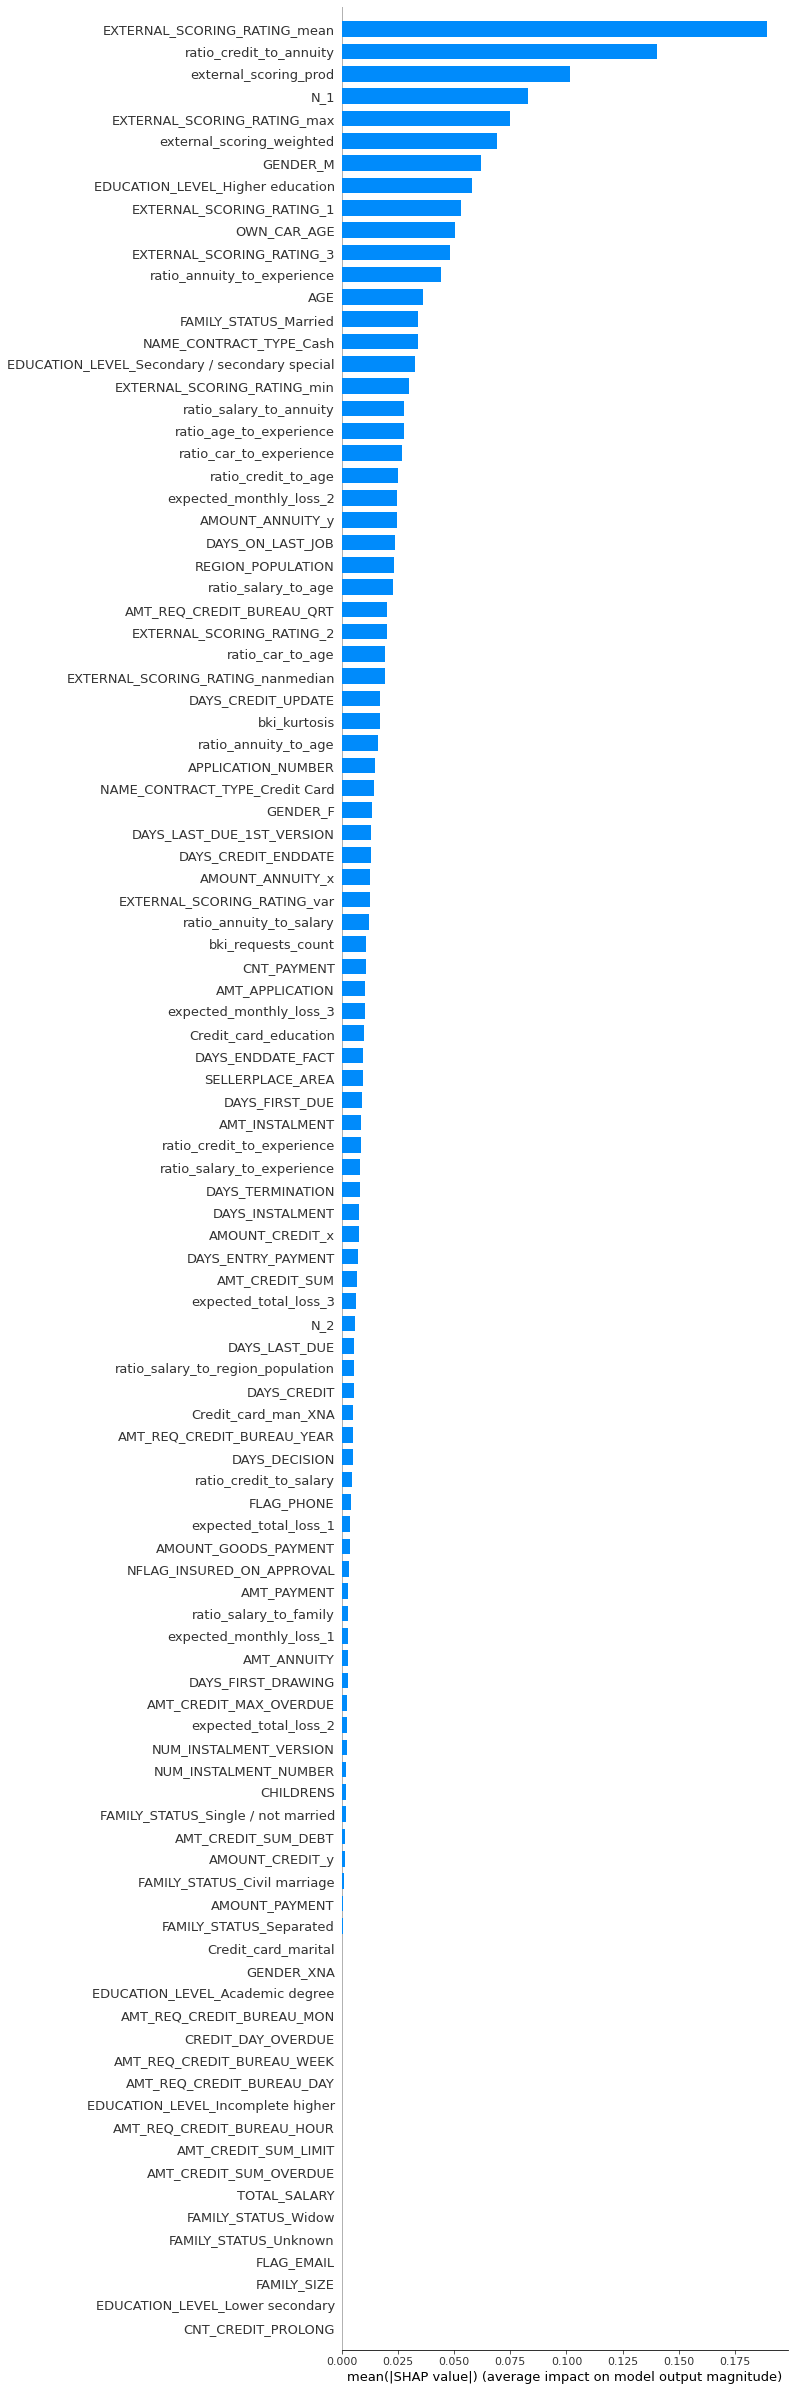

In [111]:
explainer = shap.TreeExplainer(model_xgb)
shap_values = explainer.shap_values(dvalid, y_valid)
shap.summary_plot(shap_values, x_valid, plot_type="bar", max_display=x_valid.shape[1])

In [136]:
to_drop = list(pd.DataFrame({'name': x_valid.columns, 'importance': np.mean(np.abs(shap_values), axis=0)}
                              ).sort_values(by='importance', ascending=False).reset_index(drop=True).tail(60)['name'])
to_drop

['expected_monthly_loss_3',
 'Credit_card_education',
 'DAYS_ENDDATE_FACT',
 'SELLERPLACE_AREA',
 'DAYS_FIRST_DUE',
 'AMT_INSTALMENT',
 'ratio_credit_to_experience',
 'ratio_salary_to_experience',
 'DAYS_TERMINATION',
 'DAYS_INSTALMENT',
 'AMOUNT_CREDIT_x',
 'DAYS_ENTRY_PAYMENT',
 'AMT_CREDIT_SUM',
 'expected_total_loss_3',
 'N_2',
 'DAYS_LAST_DUE',
 'ratio_salary_to_region_population',
 'DAYS_CREDIT',
 'Credit_card_man_XNA',
 'AMT_REQ_CREDIT_BUREAU_YEAR',
 'DAYS_DECISION',
 'ratio_credit_to_salary',
 'FLAG_PHONE',
 'expected_total_loss_1',
 'AMOUNT_GOODS_PAYMENT',
 'NFLAG_INSURED_ON_APPROVAL',
 'AMT_PAYMENT',
 'ratio_salary_to_family',
 'expected_monthly_loss_1',
 'AMT_ANNUITY',
 'DAYS_FIRST_DRAWING',
 'AMT_CREDIT_MAX_OVERDUE',
 'expected_total_loss_2',
 'NUM_INSTALMENT_VERSION',
 'NUM_INSTALMENT_NUMBER',
 'CHILDRENS',
 'FAMILY_STATUS_Single / not married',
 'AMT_CREDIT_SUM_DEBT',
 'AMOUNT_CREDIT_y',
 'FAMILY_STATUS_Civil marriage',
 'AMOUNT_PAYMENT',
 'FAMILY_STATUS_Separated',
 'CNT

In [137]:
x_train_shap = x_train.drop(to_drop, axis=1)
x_valid_shap = x_valid.drop(to_drop, axis=1)

In [138]:
dtrain = xgb.DMatrix(x_train_shap, label=y_train)
dvalid = xgb.DMatrix(x_valid_shap, label=y_valid)

In [139]:
xgb_estimators2, _, xgb_oof2 = xgboost_cross_validation(
    xgb_params, df_train_merged.drop(to_drop, axis=1), target, xgb_cv
)

Tue Dec 22 19:49:24 2020, Cross-Validation, 110093 rows, 44 cols
[19:49:25] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.68807	valid-auc:0.69812
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[10]	train-auc:0.70796	valid-auc:0.72345
[20]	train-auc:0.71054	valid-auc:0.72750
[30]	train-auc:0.71357	valid-auc:0.72847
[40]	train-auc:0.71636	valid-auc:0.73041
[50]	train-auc:0.71951	valid-auc:0.73072
[60]	train-auc:0.72328	valid-auc:0.73262
[70]	train-auc:0.72694	valid-auc:0.73517
[80]	train-auc:0.73068	valid-auc:0.73742
[90]	train-auc:0.73367	valid-auc:0.

[220]	train-auc:0.75657	valid-auc:0.73596
[230]	train-auc:0.75741	valid-auc:0.73609
[240]	train-auc:0.75836	valid-auc:0.73564
Stopping. Best iteration:
[221]	train-auc:0.75664	valid-auc:0.73627

Fold 5, Valid score = 0.73584
[19:50:50] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { random_seed } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.69141	valid-auc:0.68522
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[10]	train-auc:0.71031	valid-auc:0.70027
[20]	train-auc:0.71379	valid-auc:0.70248
[30]	train-auc:0.71500	valid-auc:0.70291
[40]	train-auc:0.71884	valid-auc:0.70418
[50]	train-auc:0.72291	valid-auc:0.7066

Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 25 rounds.
[10]	train-auc:0.71209	valid-auc:0.68849
[20]	train-auc:0.71501	valid-auc:0.69132
[30]	train-auc:0.71652	valid-auc:0.69037
[40]	train-auc:0.71975	valid-auc:0.69222
[50]	train-auc:0.72374	valid-auc:0.69315
[60]	train-auc:0.72745	valid-auc:0.69443
[70]	train-auc:0.73157	valid-auc:0.69730
[80]	train-auc:0.73502	valid-auc:0.69983
[90]	train-auc:0.73807	valid-auc:0.70274
[100]	train-auc:0.74085	valid-auc:0.70407
[110]	train-auc:0.74311	valid-auc:0.70505
[120]	train-auc:0.74492	valid-auc:0.70669
[130]	train-auc:0.74734	valid-auc:0.70727
[140]	train-auc:0.74864	valid-auc:0.70700
[150]	train-auc:0.75046	valid-auc:0.70762
[160]	train-auc:0.75210	valid-auc:0.70885
[170]	train-auc:0.75340	valid-auc:0.70924
[180]	train-auc:0.75438	valid-auc:0.70956
[190]	train-auc:0.75545	valid-auc:0.71017
[200]	train-auc:0.75742	valid-auc:0.71065
[210]	train-auc:0.75847	va

In [140]:
score = roc_auc_score(target, xgb_oof2)
print(f"Score = {round(score, 4)}")

Score = 0.7275


In [141]:
y_pred_xgb2 = np.zeros(df_test_merged.drop(to_drop, axis=1).shape[0])
dtest = xgb.DMatrix(data=df_test_merged.drop(to_drop, axis=1))

for estimator in xgb_estimators2:
    y_pred_xgb2 += estimator.predict(dtest)
    
y_pred_xgb2 = pd.DataFrame({
    "APPLICATION_NUMBER": test_id,
    "TARGET": y_pred_xgb2 / cv.n_splits
})

In [142]:
model_xgb2 = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=6000,
    evals=[(dtrain, "train"), (dvalid, "valid")],
    early_stopping_rounds=500,
    verbose_eval=100,
)

[19:53:28] WARNING: C:\Users\Administrator\workspace\xgboost-win64_release_1.2.0\src\learner.cc:516: 
Parameters: { min_child_weights, n_estimators } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	train-auc:0.59583	valid-auc:0.59846
Multiple eval metrics have been passed: 'valid-auc' will be used for early stopping.

Will train until valid-auc hasn't improved in 500 rounds.
[100]	train-auc:0.73861	valid-auc:0.72528
[200]	train-auc:0.74290	valid-auc:0.72613
[300]	train-auc:0.74382	valid-auc:0.72619
[400]	train-auc:0.74505	valid-auc:0.72631
[500]	train-auc:0.74660	valid-auc:0.72628
[600]	train-auc:0.74689	valid-auc:0.72641
Stopping. Best iteration:
[158]	train-auc:0.74158	valid-auc:0.72643



In [143]:

train_score = roc_auc_score(y_train, model_xgb2.predict(dtrain))
valid_score = roc_auc_score(y_valid, model_xgb2.predict(dvalid))

print(f"Train-score: {round(train_score, 3)}, Valid-score: {round(valid_score, 3)})")

Train-score: 0.747, Valid-score: 0.726)


In [144]:
y_pred_xgb_model2 = model_xgb2.predict(xgb.DMatrix(data=df_test_merged.drop(to_drop, axis=1)))
y_pred_xgb_model2 = pd.DataFrame({
    "APPLICATION_NUMBER": df_test_merged['APPLICATION_NUMBER'],
    "TARGET": y_pred_xgb_model2.flatten(),})
y_pred_xgb_model2["APPLICATION_NUMBER"] = y_pred_xgb_model2["APPLICATION_NUMBER"].astype(int)

In [ ]:
#y_pred1 - Score = 0.7263
#y_pred2 - Score = 0.7277
#y_pred_xgb - Score = 0.7259
#y_pred_xgb2 - Score = 0.7275
#y_pred_xgb_model - Valid-score: 0.727
#y_pred_xgb_model2 - Valid-score: 0.726

In [146]:
res = y_pred1.copy()
res['TARGET'] = (y_pred1['TARGET'] + y_pred2['TARGET'] + y_pred_xgb2['TARGET'] + y_pred_xgb_model['TARGET']) / 4
res.head()
res.to_csv("Kaldin_res_10.csv", index=False)